In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
from sklearn.ensemble import RandomForestClassifier


In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [4]:
ls "../../DACON"

 C 드라이브의 볼륨: SSD
 볼륨 일련 번호: BCA4-98AF

 C:\Users\inhoinno\DACON 디렉터리

2020-10-08  오후 10:53    <DIR>          .
2020-10-08  오후 10:53    <DIR>          ..
2020-09-10  오후 12:55                43 .gitattributes
2020-09-25  오전 10:56    <DIR>          .ipynb_checkpoints
2020-09-27  오후 07:22       296,271,132 03pandasP.csv
2020-09-19  오후 08:17        11,060,442 EDA_train_Inhoinno(ing).ipynb
2020-10-08  오후 11:51    <DIR>          ensemble
2020-10-05  오전 12:04        82,755,465 feature.csv
2020-09-25  오전 10:59       129,839,372 feature_train_file.csv
2020-09-10  오후 12:36         2,897,812 pandasdemo.ipynb
2020-09-10  오후 12:42           800,010 sample_submission.csv
2020-09-10  오후 12:42        18,936,246 test.csv
2020-09-27  오후 09:40        55,703,747 train.csv
2020-09-27  오후 09:36       172,560,400 train_npd.csv
2020-09-10  오후 12:37    <DIR>          단국대천체모형
              10개 파일         770,824,669 바이트
               5개 디렉터리  108,213,813,248 바이트 남음


In [5]:
data_dir = Path('../../DACON')
trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
feature_file = data_dir / 'feature.csv'
submission = pd.read_csv("../../DACON/sample_submission.csv")

val_dir = Path('../../DACON/ensemble/build/val')
tst_dir = Path('../../DACON/ensemble/build/tst')
sub_dir = Path('../../DACON/ensemble/build/sub')

algo_name = 'lgbm'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
seed = 42


In [6]:
train = pd.read_csv(trn_file)
test = pd.read_csv(tst_file)
feature= pd.concat([train,test], axis =0)
feature.fillna(-1, inplace=True)
print(train.info())
print(test.info())
print(train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320000 entries, 0 to 319999
Data columns (total 20 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         320000 non-null  int64  
 1   u          320000 non-null  float64
 2   g          320000 non-null  float64
 3   r          320000 non-null  float64
 4   i          320000 non-null  float64
 5   z          320000 non-null  float64
 6   redshift   320000 non-null  float64
 7   dered_u    320000 non-null  float64
 8   dered_g    320000 non-null  float64
 9   dered_r    320000 non-null  float64
 10  dered_i    320000 non-null  float64
 11  dered_z    320000 non-null  float64
 12  nObserve   320000 non-null  int64  
 13  nDetect    320000 non-null  int64  
 14  airmass_u  320000 non-null  float64
 15  airmass_g  320000 non-null  float64
 16  airmass_r  320000 non-null  float64
 17  airmass_i  320000 non-null  float64
 18  airmass_z  320000 non-null  float64
 19  class      320000 non-n

In [7]:
feature.describe()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
count,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,4.0000e+05,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000
mean,199999.5000,19.8539,18.3889,17.7366,17.2007,16.9299,5.8663e-02,19.6301,18.2344,17.6162,17.1654,16.8695,6.3361,6.1426,1.1758,1.1766,1.1752,1.1755,1.1762,0.6931
std,115470.1982,1.9473,27.8367,1.4687,47.0161,52.2879,5.3757e-01,1.9231,15.9262,1.4736,22.4364,35.4365,8.8795,8.5515,0.1163,0.1181,0.1147,0.1155,0.1172,1.1827
min,0.0000,-17.6875,-17555.3656,-5.4387,-23955.8178,-23955.8178,-1.6605e+02,-42.8375,-9999.0000,-16.3802,-9999.0000,-9999.0000,1.0000,1.0000,1.0001,1.0000,1.0002,1.0001,1.0000,-1.0000
25%,99999.7500,18.7248,17.4754,16.8782,16.5241,16.2888,3.5200e-05,18.5651,17.3492,16.7879,16.4537,16.2334,1.0000,1.0000,1.0882,1.0884,1.0877,1.0880,1.0883,0.0000
50%,199999.5000,19.4208,18.1414,17.5267,17.1510,16.9184,4.7127e-02,19.2652,18.0229,17.4444,17.0881,16.8701,2.0000,2.0000,1.1793,1.1792,1.1794,1.1794,1.1793,1.0000
75%,299999.2500,20.4326,19.0745,18.4289,18.0074,17.7297,9.4629e-02,20.1981,18.8902,18.2922,17.9075,17.6560,5.0000,5.0000,1.2276,1.2260,1.2293,1.2286,1.2268,2.0000
max,399999.0000,58.6233,94.3591,72.0097,50.1641,6976.3922,6.2323e+01,30.8899,30.9529,31.9572,32.0162,30.7813,44.0000,42.0000,2.0508,2.0803,2.0221,2.0363,2.0654,2.0000


In [8]:

feature.tail()

,id,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
79995,399995,19.6734,18.6617,18.2708,18.1225,18.0627,-0.0003,19.3361,18.3933,18.0860,17.9861,17.9670,17,17,1.1858,1.1863,1.1855,1.1857,1.1861,-1.0
79996,399996,21.5229,20.7283,20.6087,21.0049,20.8458,0.0655,21.3993,20.6399,20.5451,20.9507,20.7827,8,4,1.2850,1.2908,1.2793,1.2821,1.2878,-1.0
79997,399997,19.3991,18.2411,18.1605,18.1978,18.2018,-0.0008,18.9136,17.8753,17.9047,18.0043,18.0400,1,1,1.1885,1.1886,1.1885,1.1885,1.1885,-1.0
79998,399998,18.8997,17.6009,17.1329,16.8223,16.5946,0.0428,18.7715,17.4880,17.0557,16.7660,16.5585,17,17,1.1804,1.1813,1.1797,1.1800,1.1809,-1.0
79999,399999,20.7587,20.4252,20.5362,20.7729,20.9698,0.0003,20.4958,20.2181,20.3939,20.6696,20.9085,5,5,1.1832,1.1775,1.1889,1.1860,1.1803,-1.0


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         80000 non-null  int64  
 1   u          80000 non-null  float64
 2   g          80000 non-null  float64
 3   r          80000 non-null  float64
 4   i          80000 non-null  float64
 5   z          80000 non-null  float64
 6   redshift   80000 non-null  float64
 7   dered_u    80000 non-null  float64
 8   dered_g    80000 non-null  float64
 9   dered_r    80000 non-null  float64
 10  dered_i    80000 non-null  float64
 11  dered_z    80000 non-null  float64
 12  nObserve   80000 non-null  int64  
 13  nDetect    80000 non-null  int64  
 14  airmass_u  80000 non-null  float64
 15  airmass_g  80000 non-null  float64
 16  airmass_r  80000 non-null  float64
 17  airmass_i  80000 non-null  float64
 18  airmass_z  80000 non-null  float64
dtypes: float64(16), int64(3)
memory usage: 11.6 MB

In [10]:
def make_col(df):
    df['d_dered_u'] = df['dered_u'] - df['u']
    df['d_dered_g'] = df['dered_g'] - df['g']
    df['d_dered_r'] = df['dered_r'] - df['r']
    df['d_dered_i'] = df['dered_i'] - df['i']
    df['d_dered_z'] = df['dered_z'] - df['z']
    df['d_dered_rg'] = df['dered_r'] - df['dered_g']
    df['d_dered_ig'] = df['dered_i'] - df['dered_g']
    df['d_dered_zg'] = df['dered_z'] - df['dered_g']
    df['d_dered_ri'] = df['dered_r'] - df['dered_i']
    df['d_dered_rz'] = df['dered_r'] - df['dered_z']
    df['d_dered_iz'] = df['dered_i'] - df['dered_z']
    df['d_obs_det'] = df['nObserve'] - df['nDetect']

    
    # 나누기 시작
    df['n_dered_u'] = df['dered_u'] / df['u']
    df['n_dered_g'] = df['dered_g'] / df['g']
    df['n_dered_r'] = df['dered_r'] / df['r']
    df['n_dered_i'] = df['dered_i'] / df['i']
    df['n_dered_z'] = df['dered_z'] / df['z']
    df['n_dered_rg'] = df['dered_r'] / df['dered_g']
    df['n_dered_ig'] = df['dered_i'] / df['dered_g']
    df['n_dered_zg'] = df['dered_g'] / df['dered_z']
    df['n_dered_ri'] = df['dered_r'] / df['dered_i']
    df['n_dered_uz'] = df['dered_u'] / df['dered_z']
    df['n_dered_rz'] = df['dered_r'] / df['dered_z']
    df['n_dered_iz'] = df['dered_i'] / df['dered_z']
    
    # 둘이 곱하기 시작
    df['p_dered_u'] = df['d_dered_u'] * df['n_dered_u'] 
    df['p_dered_g'] = df['d_dered_g'] * df['n_dered_g']
    df['p_dered_r'] = df['d_dered_r'] * df['n_dered_r']
    df['p_dered_i'] = df['d_dered_i'] * df['n_dered_i']
    df['p_dered_z'] = df['d_dered_z'] * df['n_dered_z']
    df['d_dered_rg'] = df['d_dered_r'] * df['n_dered_g']
    df['d_dered_ig'] = df['d_dered_i'] * df['n_dered_g']
    df['d_dered_zg'] = df['d_dered_z'] * df['n_dered_g']
    df['d_dered_ri'] = df['d_dered_r'] * df['n_dered_i']
    df['d_dered_rz'] = df['d_dered_r'] * df['n_dered_z']
    df['d_dered_iz'] = df['d_dered_i'] * df['n_dered_z']
    df['d_obs_det'] = df['nObserve'] * df['nDetect']
    
    
    df.drop(['airmass_z', 'airmass_i', 'airmass_r', 'airmass_g', 'd_dered_rg', 'd_dered_ri'], axis=1, inplace=True)
    df['nObserve_log'] = df['nObserve'].apply(np.log1p)
    df['nDetect_log'] = df['nDetect'].apply(np.log1p)
    return df

In [11]:
def make_redshift(df):
    # (u  - dered_u ) / dered_u
    df['redshift_u'] = (df['u'] - df['dered_u']) / df['dered_u'] 
    df['redshift_r'] = (df['r'] - df['dered_r']) / df['dered_r'] 
    df['redshift_i'] = (df['i'] - df['dered_i']) / df['dered_i'] 
    df['redshift_g'] = (df['g'] - df['dered_g']) / df['dered_g'] 
    df['redshift_z'] = (df['z'] - df['dered_z']) / df['dered_z'] 
    return df

In [12]:
train = pd.read_csv(trn_file)
test = pd.read_csv(tst_file)
feature= pd.concat([train,test], axis =0)
feature.fillna(-1, inplace=True)
df = make_col(feature)
df = make_redshift(feature)
df_trn = make_col(train)
df_trn = make_redshift(train)

Text(0.5, 1.0, 'class vs airmass_u')

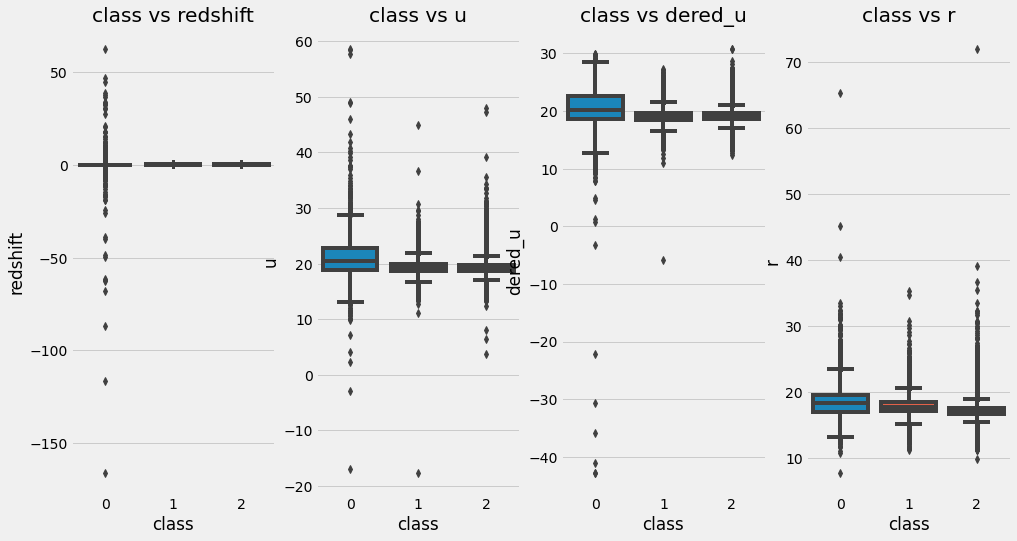

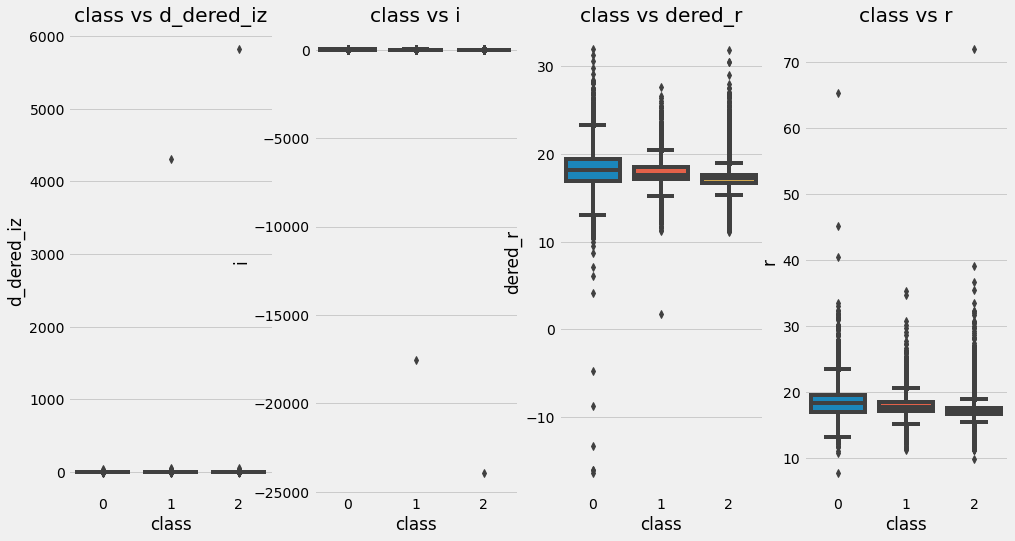

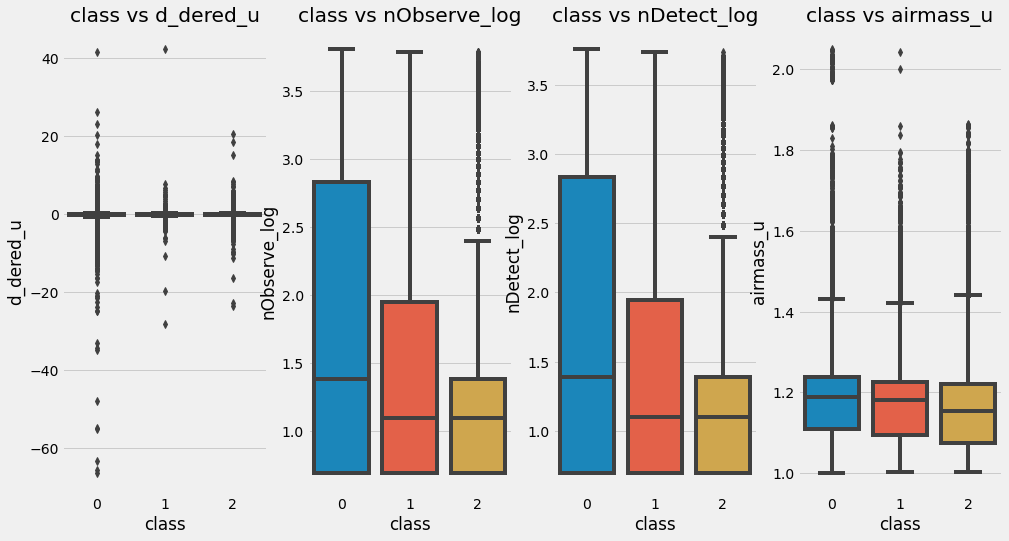

In [13]:
f , axes = plt.subplots(ncols = 4, figsize = (15,8))
data = df_trn
sns.boxplot(x = 'class', y = 'redshift', data= data, ax= axes[0])
axes[0].set_title('class vs redshift')
sns.boxplot(x = 'class', y = 'u', data= data, ax= axes[1])
axes[1].set_title('class vs u')
sns.boxplot(x = 'class', y = 'dered_u', data= data, ax= axes[2])
axes[2].set_title('class vs dered_u')
sns.boxplot(x = 'class', y = 'r', data=data, ax= axes[3])
axes[3].set_title('class vs r')

p, axes1 = plt.subplots(ncols = 4, figsize = (15,8))
sns.boxplot(x = 'class', y = 'd_dered_iz', data=data, ax= axes1[0])
axes1[0].set_title('class vs d_dered_iz')
sns.boxplot(x = 'class', y = 'i', data=data, ax= axes1[1])
axes1[1].set_title('class vs i')
sns.boxplot(x = 'class', y = 'dered_r', data= data, ax= axes1[2])
axes1[2].set_title('class vs dered_r')
sns.boxplot(x = 'class', y = 'r', data=data, ax= axes1[3])
axes1[3].set_title('class vs r')

k, axes2 = plt.subplots(ncols = 4, figsize = (15,8))
sns.boxplot(x = 'class', y = 'd_dered_u', data= data, ax= axes2[0])
axes2[0].set_title('class vs d_dered_u')
sns.boxplot(x = 'class', y = 'nObserve_log', data=data, ax= axes2[1])
axes2[1].set_title('class vs nObserve_log')
sns.boxplot(x = 'class', y = 'nDetect_log', data=data, ax= axes2[2])
axes2[2].set_title('class vs nDetect_log')
sns.boxplot(x = 'class', y = 'airmass_u', data= data, ax= axes2[3])
axes2[3].set_title('class vs airmass_u')


In [14]:
target_col = 'class'
pred_col = 'pred'
num_cols = [x for x in train.columns if train[x].dtype in [np.int64, np.float64] and x != target_col]
print(num_cols)

['id', 'u', 'g', 'r', 'i', 'z', 'redshift', 'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z', 'nObserve', 'nDetect', 'airmass_u', 'd_dered_u', 'd_dered_g', 'd_dered_r', 'd_dered_i', 'd_dered_z', 'd_dered_ig', 'd_dered_zg', 'd_dered_rz', 'd_dered_iz', 'd_obs_det', 'n_dered_u', 'n_dered_g', 'n_dered_r', 'n_dered_i', 'n_dered_z', 'n_dered_rg', 'n_dered_ig', 'n_dered_zg', 'n_dered_ri', 'n_dered_uz', 'n_dered_rz', 'n_dered_iz', 'p_dered_u', 'p_dered_g', 'p_dered_r', 'p_dered_i', 'p_dered_z', 'nObserve_log', 'nDetect_log', 'redshift_u', 'redshift_r', 'redshift_i', 'redshift_g', 'redshift_z']


In [15]:
cols_to_use = ['redshift', 
               'd_dered_u', 'd_dered_g', 'd_dered_r', 'd_dered_i', 'd_dered_z', 'd_dered_zg', 'd_dered_rz', 'd_dered_iz', 
               'n_dered_u', 'n_dered_g', 'n_dered_r', 'n_dered_i', 'n_dered_z','n_dered_uz','n_dered_zg','n_dered_rg','n_dered_ri','n_dered_rz','n_dered_iz',
               'nObserve_log', 'nDetect_log']
#이 중 정규화를 했으면 좋겠는 열은 g, z, dered_z
#이외로 train에서는 i,dered_g, dered_i에서 Outlier가 있고
# test 에서는 g,z,dered_z
# Redshift의 경우 제일 영향이 많은 Column이므로 섣부른 정규화는 조심히 수행하자
cols_to_scale = ['g','z','dered_z']
cols_to_use

['redshift',
 'd_dered_u',
 'd_dered_g',
 'd_dered_r',
 'd_dered_i',
 'd_dered_z',
 'd_dered_zg',
 'd_dered_rz',
 'd_dered_iz',
 'n_dered_u',
 'n_dered_g',
 'n_dered_r',
 'n_dered_i',
 'n_dered_z',
 'n_dered_uz',
 'n_dered_zg',
 'n_dered_rg',
 'n_dered_ri',
 'n_dered_rz',
 'n_dered_iz',
 'nObserve_log',
 'nDetect_log']

In [16]:
cols_to_use_best = ['redshift',
 'dered_u',
 'dered_g',
 'dered_r',
 'dered_i',
 'dered_z',
 'airmass_u',
 'd_dered_ig',
 'd_dered_zg',
 'd_dered_rz',
 'd_dered_iz',

 'n_dered_u',
 'n_dered_g',
 'n_dered_r',
 'n_dered_i',
 'n_dered_z',
 'n_dered_rg',
 'n_dered_ig',
 'n_dered_zg',
 'n_dered_ri',
 'n_dered_rz',
 #'n_dered_iz',#?
 
 'nObserve_log',
 'nDetect_log'] #93.40

In [17]:
cols_clean = ['u', 'g', 'r', 'i', 'z', 'redshift', 'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z','nObserve_log', 'nDetect_log']
d_cols = [ 'redshift','d_dered_u', 'd_dered_g', 'd_dered_r', 'd_dered_i', 'd_dered_z', 'd_dered_zg', 'd_dered_rz', 'd_dered_iz',]
d_cols_m = [ 'redshift','d_dered_ig','d_dered_zg','d_dered_rz','d_dered_iz']
n_cols = ['redshift','n_dered_u', 'n_dered_g', 'n_dered_r', 'n_dered_i', 'n_dered_z']
n_cols_m = ['redshift','n_dered_rg','n_dered_ig','n_dered_zg','n_dered_ri','n_dered_rz','n_dered_iz']
p_cols = ['redshift','p_dered_u', 'p_dered_g', 'p_dered_r', 'p_dered_i', 'p_dered_z'] 
p_cols_m = ['redshift', 'p_dered_rg', 'p_dered_ru', 'p_dered_ig', 'p_dered_zg', 'p_dered_ri', 'p_dered_rz', 'p_dered_iz']

In [18]:
cols_proba = list()

In [19]:
df_trn[cols_clean+['class']].corr().style.background_gradient()
#상관관계가 높을 수록 진하게 나타낸다
# > 'g','i','z','redshift','dered_g', 'dered_i', 'dered_z'
cols_proba.append(['g','i','z','redshift','dered_g', 'dered_i', 'dered_z'])

In [20]:
df_trn[d_cols + ['class']].corr().style.background_gradient()
# 'd_dered_u','d_dered_r' , 'd_dered_i', 'd_dered_z' , 'd_dered_zg' , 'd_dered_rz', 'd_dered_iz'
cols_proba.append(['d_dered_u','d_dered_r' , 'd_dered_i', 'd_dered_z' , 'd_dered_zg' , 'd_dered_rz', 'd_dered_iz'])

In [21]:
df_trn[d_cols_m + ['class']].corr().style.background_gradient()
# > 'd_dered_ig' ,'d_dered_zg', 'd_dered_rz', 'd_dered_iz'
cols_proba.append(['d_dered_ig' ,'d_dered_zg', 'd_dered_rz', 'd_dered_iz'])

In [22]:
df_trn[n_cols + ['class']].corr().style.background_gradient()
# > 'n_dered_u' , 'n_dered_r', 'n_dered_g', 'n_dered_i'
#plt.figure(figsize=(15,15))
#sns.heatmap(data = df_trn[n_cols + ['class']].corr(), annot=True, 
#fmt = '.2f', linewidths=.5, cmap='Blues')
cols_proba.append(['n_dered_u' , 'n_dered_r', 'n_dered_g', 'n_dered_i'])

In [23]:
df_trn[n_cols_m + ['class']].corr().style.background_gradient()
#> ''n_dered_rg' 'n_dered_ri' 'n_dered_iz','n_dered_rz' 
#plt.figure(figsize=(15,15))
#sns.heatmap(data = df_trn[n_cols_m + ['class']].corr(), annot=True, 
#fmt = '.2f', linewidths=.5, cmap='Blues')
cols_proba.append(['n_dered_rg' 'n_dered_ri' 'n_dered_iz','n_dered_rz'])

In [24]:
df_trn[p_cols + ['class']].corr().style.background_gradient()
# > 'p_dered_r'
#plt.figure(figsize=(15,15))
# 'p_dered_u', 'p_dered_r'
#sns.heatmap(data = df_trn[p_cols + ['class']].corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues')
cols_proba.append(['p_dered_u', 'p_dered_r'])

In [25]:
df[cols_to_use_best + ['class']].corr().style.background_gradient()
#상관관계가 높을 수록 진하게 나타낸다

,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,airmass_u,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,n_dered_u,n_dered_g,n_dered_r,n_dered_i,n_dered_z,n_dered_rg,n_dered_ig,n_dered_zg,n_dered_ri,n_dered_rz,nObserve_log,nDetect_log,class
redshift,1.0000,-0.0080,-0.0002,-0.0028,-0.0001,-0.0001,0.0011,0.0001,0.0001,0.0028,0.0002,0.0007,0.0053,0.0084,0.0060,0.0003,-0.0062,-0.0001,-0.0007,-0.0019,-0.0031,-0.0092,-0.0089,0.0484
dered_u,-0.0080,1.0000,0.0969,0.8392,0.0423,0.0249,0.0889,-0.0002,0.0030,0.0282,0.0017,0.0461,0.1061,0.1439,0.1222,0.0448,-0.3148,-0.0269,0.2312,0.1638,0.2680,0.2337,0.2265,-0.2120
dered_g,-0.0002,0.0969,1.0000,0.0990,0.7072,0.4476,0.0071,-0.2953,-0.1914,0.0023,-0.5904,0.0053,0.0255,0.0150,0.0420,0.0169,0.0145,-0.0025,0.0216,0.0298,0.0409,0.0222,0.0215,-0.0219
dered_r,-0.0028,0.8392,0.0990,1.0000,0.0549,0.0340,0.0848,0.0007,0.0043,0.0213,0.0025,0.0453,0.1016,0.1385,0.1220,0.0330,-0.0387,-0.0121,0.1299,0.1224,0.1932,0.2100,0.1994,-0.2139
dered_i,-0.0001,0.0423,0.7072,0.0549,1.0000,0.6331,0.0026,-0.8835,-0.5736,0.0013,-0.9864,0.0026,0.0157,0.0082,0.0561,0.0238,0.0308,0.7044,0.0090,0.0221,0.0266,0.0118,0.0116,-0.0136
dered_z,-0.0001,0.0249,0.4476,0.0340,0.6331,1.0000,-0.0010,-0.5594,0.0175,0.0006,-0.6246,0.0015,0.0094,0.0042,0.0346,0.0442,0.0218,0.4461,0.0140,0.0131,0.0341,0.0075,0.0075,-0.0090
airmass_u,0.0011,0.0889,0.0071,0.0848,0.0026,-0.0010,1.0000,0.0024,-0.0011,0.0073,0.0031,0.0112,0.0200,0.0299,0.0258,0.0077,-0.0186,-0.0030,0.0071,0.0039,0.0064,0.2507,0.2491,-0.0483
d_dered_ig,0.0001,-0.0002,-0.2953,0.0007,-0.8835,-0.5594,0.0024,1.0000,0.6494,0.0028,0.9442,0.0010,0.0011,0.0042,-0.0417,-0.0180,-0.0120,-0.9527,-0.0087,-0.0187,-0.0205,0.0003,-0.0001,0.0026
d_dered_zg,0.0001,0.0030,-0.1914,0.0043,-0.5736,0.0175,-0.0011,0.6494,1.0000,0.0137,0.6132,0.0010,0.0073,0.0032,-0.0283,0.0527,-0.0073,-0.6188,0.0014,-0.0121,0.0003,0.0013,0.0011,0.0031
d_dered_rz,0.0028,0.0282,0.0023,0.0213,0.0013,0.0006,0.0073,0.0028,0.0137,1.0000,0.0080,0.0439,0.5442,0.4073,0.1230,0.8228,-0.0068,-0.0003,0.0065,0.0079,0.0056,-0.0071,-0.0069,0.0232


In [26]:
cols_redshift = ['redshift','redshift_u', 'redshift_r', 'redshift_i', 'redshift_g', 'redshift_z']

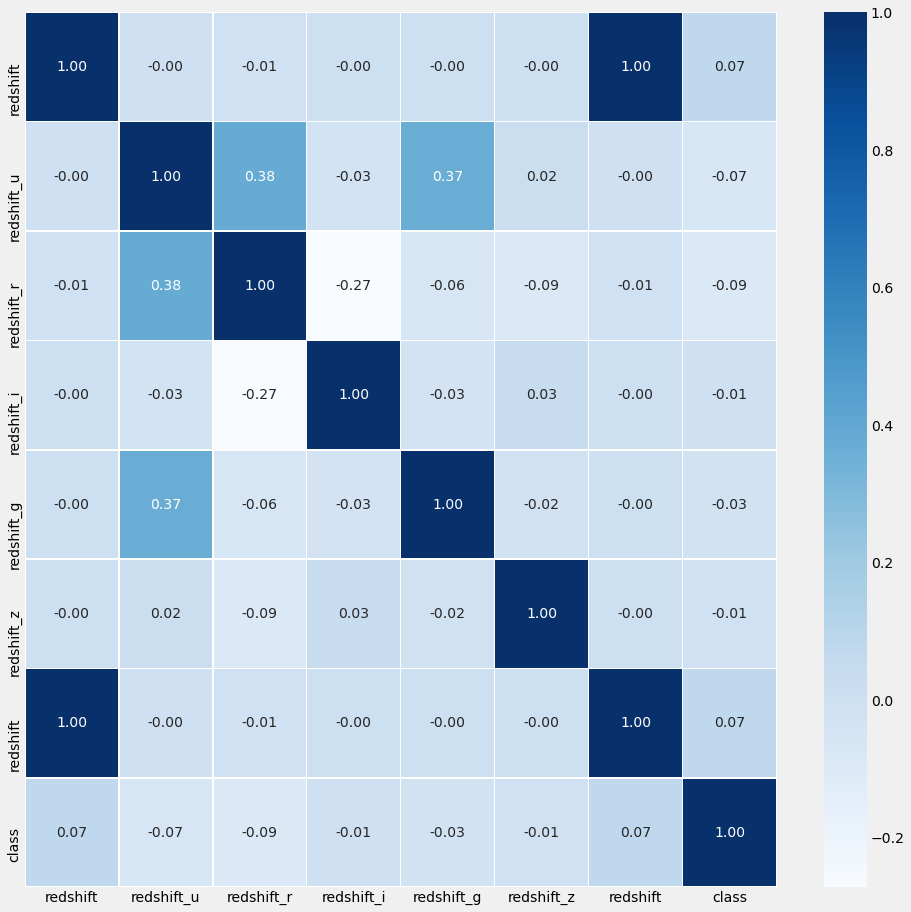

In [27]:
df_trn[cols_redshift + ['class']].corr().style.background_gradient()
plt.figure(figsize=(15,15))
# ?
sns.heatmap(data = df_trn[cols_redshift + ['redshift','class']].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [28]:
class12 = df_trn[df_trn['class'] != 0]

In [29]:
class12.corr().style.background_gradient()

In [30]:
cols_clean = ['u', 'g', 'r', 'i', 'z', 'redshift', 'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z','nObserve_log', 'nDetect_log']
d_cols = [ 'redshift','d_dered_u', 'd_dered_g', 'd_dered_r', 'd_dered_i', 'd_dered_z', 'd_dered_zg', 'd_dered_rz', 'd_dered_iz',]
d_cols_m = [ 'redshift','d_dered_ig','d_dered_zg','d_dered_rz','d_dered_iz']
n_cols = ['redshift','n_dered_u', 'n_dered_g', 'n_dered_r', 'n_dered_i', 'n_dered_z']
n_cols_m = ['redshift','n_dered_rg','n_dered_ig','n_dered_zg','n_dered_ri','n_dered_rz','n_dered_iz']
p_cols = ['redshift','p_dered_u', 'p_dered_g', 'p_dered_r', 'p_dered_i', 'p_dered_z'] 
p_cols_m = ['redshift', 'p_dered_rg', 'p_dered_ru', 'p_dered_ig', 'p_dered_zg', 'p_dered_ri', 'p_dered_rz', 'p_dered_iz']
cols_redshift = ['redshift','redshift_u', 'redshift_r', 'redshift_i', 'redshift_g', 'redshift_z']
#cols_to_use
#cols_to_use_best
cols_to_use_fin = [
    'redshift', 
    'dered_u',
    'dered_r',
    'dered_g', 
    'dered_i', 
    'dered_z',
 'd_dered_u',
  'd_dered_r',
  'd_dered_i',
  'd_dered_z',
  'd_dered_zg',
    'd_dered_uz',
  'd_dered_rz',
  'd_dered_iz',
 'd_dered_ig',
 'n_dered_rg','n_dered_ri', 'n_dered_iz', 'n_dered_rz',
'n_dered_zg',
'n_dered_ri',
'n_dered_uz',
]


In [31]:
#Normal
#X = df_trn[cols_to_use]
#X2 = df_trn[cols_to_use_best]
#X_f = df_trn[cols_to_use_fin]

#X_d = df_trn[d_cols]
#X_dm = df_trn[d_cols_m]
#X_n = df_trn[n_cols]
#X_nm = df_trn[n_cols_m]
#X_p = df_trn[p_cols]
#X_pm = df_trn[p_cols_m]
#X_r = df_trn[cols_redshift]
#y = df_trn[target_col]

In [32]:
#X_trn2, X_val2, y_trn, y_val = train_test_split(X2, y, test_size=.2, random_state=seed)
#X_trnf, X_valf, y_trn, y_val = train_test_split(X_f, y, test_size=.2, random_state=seed)
#X_trnd, X_vald, y_trn, y_val = train_test_split(X_d, y, test_size=.2, random_state=seed)
#X_trndm, X_valdm, y_trn, y_val = train_test_split(X_dm, y, test_size=.2, random_state=seed)
#X_trnn, X_valn, y_trn, y_val = train_test_split(X_n, y, test_size=.2, random_state=seed)
#X_trnnm, X_valnm, y_trn, y_val = train_test_split(X_nm, y, test_size=.2, random_state=seed)
#X_trnp, X_valp, y_trn, y_val = train_test_split(X_p, y, test_size=.2, random_state=seed)
#X_trnr, X_valr, y_trn, y_val = train_test_split(X_r, y, test_size=.2, random_state=seed)


<h1> LGBM </h1>

<h4>LBGM model 1) Hyper Optuna</h4>

In [33]:
import lightgbm as lgb

In [34]:
#Normal
X = df_trn[cols_to_use]
y = df_trn[target_col]
seed = 8

In [35]:
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=.2, random_state=seed)

In [36]:
params = {
    "objective": "multiclass",
    "n_estimators": 1000,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
    "num_leaves": hp.choice("num_leaves", np.arange(80, 280,2)),
    "colsample_bytree": hp.quniform("colsample_bytree", .7, .9, 0.05),
    "subsample": hp.quniform("subsample", .8, 1.0, 0.05),
    "min_child_samples": hp.choice('min_child_samples', np.arange(50,80,5))
}

In [37]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",
              early_stopping_rounds=30,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

100%|██████████| 10/10 [03:14<00:00, 19.49s/trial, best loss: 0.15635246153561047]
{'objective': 'multiclass', 'n_estimators': 1000, 'subsample_freq': 1, 'random_state': 8, 'n_jobs': -1, 'colsample_bytree': 0.75, 'learning_rate': 0.01661883186255677, 'min_child_samples': 65, 'num_leaves': 176, 'subsample': 0.9500000000000001}


LGBM CV

In [38]:
#n_stacking =30 #5 for lgbm * 2 ,  5 for xgboost *2 , 5 for rf * 2 
n_fold = 5
n_class = 3
#cv = KFold(n_splits = n_fold, shuffle = True, random_state = 1)
cv = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = 1)

In [39]:
y = df[target_col].values[:320000]
trn = df[cols_to_use].iloc[:320000].values
tst = df[cols_to_use].iloc[320000:].values
feature_name = df[cols_to_use].columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 22) (80000, 22)


In [40]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst0 = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    lgb_clf0 = lgb.LGBMClassifier(**params)
    lgb_clf0.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            early_stopping_rounds=30)
    p_val[i_val, :] = lgb_clf0.predict_proba(trn[i_val])
    p_tst0 += lgb_clf0.predict_proba(tst) / n_fold #n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.961317
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 0.937211
[3]	valid_0's multi_logloss: 0.914191
[4]	valid_0's multi_logloss: 0.893345
[5]	valid_0's multi_logloss: 0.873226
[6]	valid_0's multi_logloss: 0.852647
[7]	valid_0's multi_logloss: 0.833079
[8]	valid_0's multi_logloss: 0.814152
[9]	valid_0's multi_logloss: 0.796483
[10]	valid_0's multi_logloss: 0.780597
[11]	valid_0's multi_logloss: 0.764629
[12]	valid_0's multi_logloss: 0.749002
[13]	valid_0's multi_logloss: 0.734036
[14]	valid_0's multi_logloss: 0.718934
[15]	valid_0's multi_logloss: 0.704107
[16]	valid_0's multi_logloss: 0.689977
[17]	valid_0's multi_logloss: 0.67647
[18]	valid_0's multi_logloss: 0.663032
[19]	valid_0's multi_logloss: 0.650162
[20]	valid_0's multi_logloss: 0.638474
[21]	valid_0's multi_logloss: 0.627292
[22]	valid_0's multi_logloss: 0.616232
[23]	valid_0's multi_logloss: 0.60477
[24]	valid_0's multi_logloss

[208]	valid_0's multi_logloss: 0.172438
[209]	valid_0's multi_logloss: 0.172237
[210]	valid_0's multi_logloss: 0.172056
[211]	valid_0's multi_logloss: 0.171853
[212]	valid_0's multi_logloss: 0.171695
[213]	valid_0's multi_logloss: 0.171541
[214]	valid_0's multi_logloss: 0.171328
[215]	valid_0's multi_logloss: 0.171127
[216]	valid_0's multi_logloss: 0.170918
[217]	valid_0's multi_logloss: 0.170747
[218]	valid_0's multi_logloss: 0.170578
[219]	valid_0's multi_logloss: 0.17039
[220]	valid_0's multi_logloss: 0.170186
[221]	valid_0's multi_logloss: 0.170053
[222]	valid_0's multi_logloss: 0.169851
[223]	valid_0's multi_logloss: 0.16969
[224]	valid_0's multi_logloss: 0.169512
[225]	valid_0's multi_logloss: 0.169326
[226]	valid_0's multi_logloss: 0.169148
[227]	valid_0's multi_logloss: 0.16897
[228]	valid_0's multi_logloss: 0.1688
[229]	valid_0's multi_logloss: 0.168642
[230]	valid_0's multi_logloss: 0.168509
[231]	valid_0's multi_logloss: 0.168354
[232]	valid_0's multi_logloss: 0.168194
[233]

[413]	valid_0's multi_logloss: 0.158858
[414]	valid_0's multi_logloss: 0.158846
[415]	valid_0's multi_logloss: 0.158832
[416]	valid_0's multi_logloss: 0.158825
[417]	valid_0's multi_logloss: 0.15881
[418]	valid_0's multi_logloss: 0.158796
[419]	valid_0's multi_logloss: 0.158786
[420]	valid_0's multi_logloss: 0.158771
[421]	valid_0's multi_logloss: 0.15876
[422]	valid_0's multi_logloss: 0.158753
[423]	valid_0's multi_logloss: 0.15875
[424]	valid_0's multi_logloss: 0.158736
[425]	valid_0's multi_logloss: 0.158728
[426]	valid_0's multi_logloss: 0.158715
[427]	valid_0's multi_logloss: 0.158706
[428]	valid_0's multi_logloss: 0.158701
[429]	valid_0's multi_logloss: 0.158686
[430]	valid_0's multi_logloss: 0.158671
[431]	valid_0's multi_logloss: 0.158661
[432]	valid_0's multi_logloss: 0.158651
[433]	valid_0's multi_logloss: 0.158639
[434]	valid_0's multi_logloss: 0.158628
[435]	valid_0's multi_logloss: 0.158613
[436]	valid_0's multi_logloss: 0.1586
[437]	valid_0's multi_logloss: 0.158589
[438]

[12]	valid_0's multi_logloss: 0.749495
[13]	valid_0's multi_logloss: 0.734558
[14]	valid_0's multi_logloss: 0.719495
[15]	valid_0's multi_logloss: 0.704672
[16]	valid_0's multi_logloss: 0.690562
[17]	valid_0's multi_logloss: 0.677092
[18]	valid_0's multi_logloss: 0.663678
[19]	valid_0's multi_logloss: 0.650834
[20]	valid_0's multi_logloss: 0.63917
[21]	valid_0's multi_logloss: 0.627983
[22]	valid_0's multi_logloss: 0.616919
[23]	valid_0's multi_logloss: 0.605451
[24]	valid_0's multi_logloss: 0.594306
[25]	valid_0's multi_logloss: 0.583771
[26]	valid_0's multi_logloss: 0.573934
[27]	valid_0's multi_logloss: 0.564879
[28]	valid_0's multi_logloss: 0.555713
[29]	valid_0's multi_logloss: 0.546087
[30]	valid_0's multi_logloss: 0.537285
[31]	valid_0's multi_logloss: 0.528438
[32]	valid_0's multi_logloss: 0.519595
[33]	valid_0's multi_logloss: 0.511027
[34]	valid_0's multi_logloss: 0.502671
[35]	valid_0's multi_logloss: 0.495303
[36]	valid_0's multi_logloss: 0.487849
[37]	valid_0's multi_loglo

[221]	valid_0's multi_logloss: 0.171642
[222]	valid_0's multi_logloss: 0.171446
[223]	valid_0's multi_logloss: 0.171294
[224]	valid_0's multi_logloss: 0.171129
[225]	valid_0's multi_logloss: 0.170959
[226]	valid_0's multi_logloss: 0.17078
[227]	valid_0's multi_logloss: 0.170608
[228]	valid_0's multi_logloss: 0.170453
[229]	valid_0's multi_logloss: 0.170293
[230]	valid_0's multi_logloss: 0.170154
[231]	valid_0's multi_logloss: 0.169996
[232]	valid_0's multi_logloss: 0.169842
[233]	valid_0's multi_logloss: 0.169703
[234]	valid_0's multi_logloss: 0.169555
[235]	valid_0's multi_logloss: 0.169391
[236]	valid_0's multi_logloss: 0.169251
[237]	valid_0's multi_logloss: 0.169143
[238]	valid_0's multi_logloss: 0.169023
[239]	valid_0's multi_logloss: 0.168882
[240]	valid_0's multi_logloss: 0.168764
[241]	valid_0's multi_logloss: 0.16865
[242]	valid_0's multi_logloss: 0.168515
[243]	valid_0's multi_logloss: 0.168383
[244]	valid_0's multi_logloss: 0.168287
[245]	valid_0's multi_logloss: 0.168165
[2

[430]	valid_0's multi_logloss: 0.160546
[431]	valid_0's multi_logloss: 0.160541
[432]	valid_0's multi_logloss: 0.160528
[433]	valid_0's multi_logloss: 0.160526
[434]	valid_0's multi_logloss: 0.160514
[435]	valid_0's multi_logloss: 0.160504
[436]	valid_0's multi_logloss: 0.160495
[437]	valid_0's multi_logloss: 0.160485
[438]	valid_0's multi_logloss: 0.16048
[439]	valid_0's multi_logloss: 0.160476
[440]	valid_0's multi_logloss: 0.160465
[441]	valid_0's multi_logloss: 0.160456
[442]	valid_0's multi_logloss: 0.160449
[443]	valid_0's multi_logloss: 0.16044
[444]	valid_0's multi_logloss: 0.160431
[445]	valid_0's multi_logloss: 0.160427
[446]	valid_0's multi_logloss: 0.160415
[447]	valid_0's multi_logloss: 0.160404
[448]	valid_0's multi_logloss: 0.160399
[449]	valid_0's multi_logloss: 0.160391
[450]	valid_0's multi_logloss: 0.160386
[451]	valid_0's multi_logloss: 0.16038
[452]	valid_0's multi_logloss: 0.160372
[453]	valid_0's multi_logloss: 0.160369
[454]	valid_0's multi_logloss: 0.160361
[45

[48]	valid_0's multi_logloss: 0.410095
[49]	valid_0's multi_logloss: 0.404514
[50]	valid_0's multi_logloss: 0.399265
[51]	valid_0's multi_logloss: 0.393945
[52]	valid_0's multi_logloss: 0.388716
[53]	valid_0's multi_logloss: 0.383614
[54]	valid_0's multi_logloss: 0.378671
[55]	valid_0's multi_logloss: 0.373976
[56]	valid_0's multi_logloss: 0.369734
[57]	valid_0's multi_logloss: 0.365309
[58]	valid_0's multi_logloss: 0.360782
[59]	valid_0's multi_logloss: 0.3564
[60]	valid_0's multi_logloss: 0.352377
[61]	valid_0's multi_logloss: 0.348174
[62]	valid_0's multi_logloss: 0.344069
[63]	valid_0's multi_logloss: 0.340208
[64]	valid_0's multi_logloss: 0.336312
[65]	valid_0's multi_logloss: 0.332498
[66]	valid_0's multi_logloss: 0.329261
[67]	valid_0's multi_logloss: 0.325817
[68]	valid_0's multi_logloss: 0.322536
[69]	valid_0's multi_logloss: 0.319081
[70]	valid_0's multi_logloss: 0.315679
[71]	valid_0's multi_logloss: 0.312432
[72]	valid_0's multi_logloss: 0.309391
[73]	valid_0's multi_loglos

[257]	valid_0's multi_logloss: 0.166158
[258]	valid_0's multi_logloss: 0.166043
[259]	valid_0's multi_logloss: 0.165951
[260]	valid_0's multi_logloss: 0.165854
[261]	valid_0's multi_logloss: 0.165762
[262]	valid_0's multi_logloss: 0.165654
[263]	valid_0's multi_logloss: 0.165565
[264]	valid_0's multi_logloss: 0.165486
[265]	valid_0's multi_logloss: 0.165403
[266]	valid_0's multi_logloss: 0.165322
[267]	valid_0's multi_logloss: 0.165221
[268]	valid_0's multi_logloss: 0.165129
[269]	valid_0's multi_logloss: 0.16506
[270]	valid_0's multi_logloss: 0.164966
[271]	valid_0's multi_logloss: 0.164888
[272]	valid_0's multi_logloss: 0.164826
[273]	valid_0's multi_logloss: 0.164767
[274]	valid_0's multi_logloss: 0.164701
[275]	valid_0's multi_logloss: 0.164612
[276]	valid_0's multi_logloss: 0.164549
[277]	valid_0's multi_logloss: 0.164473
[278]	valid_0's multi_logloss: 0.1644
[279]	valid_0's multi_logloss: 0.164322
[280]	valid_0's multi_logloss: 0.164256
[281]	valid_0's multi_logloss: 0.164188
[28

[462]	valid_0's multi_logloss: 0.159334
[463]	valid_0's multi_logloss: 0.159325
[464]	valid_0's multi_logloss: 0.159312
[465]	valid_0's multi_logloss: 0.159302
[466]	valid_0's multi_logloss: 0.159296
[467]	valid_0's multi_logloss: 0.159288
[468]	valid_0's multi_logloss: 0.159285
[469]	valid_0's multi_logloss: 0.15928
[470]	valid_0's multi_logloss: 0.159266
[471]	valid_0's multi_logloss: 0.15926
[472]	valid_0's multi_logloss: 0.159261
[473]	valid_0's multi_logloss: 0.159258
[474]	valid_0's multi_logloss: 0.159251
[475]	valid_0's multi_logloss: 0.159239
[476]	valid_0's multi_logloss: 0.15923
[477]	valid_0's multi_logloss: 0.159233
[478]	valid_0's multi_logloss: 0.159224
[479]	valid_0's multi_logloss: 0.159216
[480]	valid_0's multi_logloss: 0.159214
[481]	valid_0's multi_logloss: 0.159211
[482]	valid_0's multi_logloss: 0.15921
[483]	valid_0's multi_logloss: 0.159208
[484]	valid_0's multi_logloss: 0.159203
[485]	valid_0's multi_logloss: 0.159195
[486]	valid_0's multi_logloss: 0.159186
[487

[57]	valid_0's multi_logloss: 0.364488
[58]	valid_0's multi_logloss: 0.359955
[59]	valid_0's multi_logloss: 0.355553
[60]	valid_0's multi_logloss: 0.351534
[61]	valid_0's multi_logloss: 0.347331
[62]	valid_0's multi_logloss: 0.343223
[63]	valid_0's multi_logloss: 0.339356
[64]	valid_0's multi_logloss: 0.335468
[65]	valid_0's multi_logloss: 0.331648
[66]	valid_0's multi_logloss: 0.328414
[67]	valid_0's multi_logloss: 0.324977
[68]	valid_0's multi_logloss: 0.321672
[69]	valid_0's multi_logloss: 0.318226
[70]	valid_0's multi_logloss: 0.314828
[71]	valid_0's multi_logloss: 0.311578
[72]	valid_0's multi_logloss: 0.308539
[73]	valid_0's multi_logloss: 0.305415
[74]	valid_0's multi_logloss: 0.302481
[75]	valid_0's multi_logloss: 0.299487
[76]	valid_0's multi_logloss: 0.296523
[77]	valid_0's multi_logloss: 0.294087
[78]	valid_0's multi_logloss: 0.291558
[79]	valid_0's multi_logloss: 0.288958
[80]	valid_0's multi_logloss: 0.286542
[81]	valid_0's multi_logloss: 0.283918
[82]	valid_0's multi_logl

[266]	valid_0's multi_logloss: 0.16381
[267]	valid_0's multi_logloss: 0.163704
[268]	valid_0's multi_logloss: 0.163618
[269]	valid_0's multi_logloss: 0.163537
[270]	valid_0's multi_logloss: 0.163446
[271]	valid_0's multi_logloss: 0.163371
[272]	valid_0's multi_logloss: 0.163324
[273]	valid_0's multi_logloss: 0.163272
[274]	valid_0's multi_logloss: 0.163213
[275]	valid_0's multi_logloss: 0.163115
[276]	valid_0's multi_logloss: 0.16305
[277]	valid_0's multi_logloss: 0.162981
[278]	valid_0's multi_logloss: 0.162917
[279]	valid_0's multi_logloss: 0.162839
[280]	valid_0's multi_logloss: 0.162763
[281]	valid_0's multi_logloss: 0.16269
[282]	valid_0's multi_logloss: 0.162629
[283]	valid_0's multi_logloss: 0.162565
[284]	valid_0's multi_logloss: 0.162482
[285]	valid_0's multi_logloss: 0.162404
[286]	valid_0's multi_logloss: 0.162329
[287]	valid_0's multi_logloss: 0.162287
[288]	valid_0's multi_logloss: 0.162228
[289]	valid_0's multi_logloss: 0.162153
[290]	valid_0's multi_logloss: 0.162114
[29

[474]	valid_0's multi_logloss: 0.157563
[475]	valid_0's multi_logloss: 0.157564
[476]	valid_0's multi_logloss: 0.15756
[477]	valid_0's multi_logloss: 0.157556
[478]	valid_0's multi_logloss: 0.157546
[479]	valid_0's multi_logloss: 0.157538
[480]	valid_0's multi_logloss: 0.157531
[481]	valid_0's multi_logloss: 0.157529
[482]	valid_0's multi_logloss: 0.157529
[483]	valid_0's multi_logloss: 0.157533
[484]	valid_0's multi_logloss: 0.157529
[485]	valid_0's multi_logloss: 0.157533
[486]	valid_0's multi_logloss: 0.157528
[487]	valid_0's multi_logloss: 0.157528
[488]	valid_0's multi_logloss: 0.157523
[489]	valid_0's multi_logloss: 0.157516
[490]	valid_0's multi_logloss: 0.157511
[491]	valid_0's multi_logloss: 0.157506
[492]	valid_0's multi_logloss: 0.157507
[493]	valid_0's multi_logloss: 0.157503
[494]	valid_0's multi_logloss: 0.157492
[495]	valid_0's multi_logloss: 0.15749
[496]	valid_0's multi_logloss: 0.157487
[497]	valid_0's multi_logloss: 0.157488
[498]	valid_0's multi_logloss: 0.157487
[4

[88]	valid_0's multi_logloss: 0.265233
[89]	valid_0's multi_logloss: 0.263075
[90]	valid_0's multi_logloss: 0.260872
[91]	valid_0's multi_logloss: 0.258731
[92]	valid_0's multi_logloss: 0.256644
[93]	valid_0's multi_logloss: 0.254626
[94]	valid_0's multi_logloss: 0.252937
[95]	valid_0's multi_logloss: 0.25098
[96]	valid_0's multi_logloss: 0.249191
[97]	valid_0's multi_logloss: 0.247465
[98]	valid_0's multi_logloss: 0.245618
[99]	valid_0's multi_logloss: 0.244029
[100]	valid_0's multi_logloss: 0.24228
[101]	valid_0's multi_logloss: 0.240856
[102]	valid_0's multi_logloss: 0.239164
[103]	valid_0's multi_logloss: 0.237502
[104]	valid_0's multi_logloss: 0.235953
[105]	valid_0's multi_logloss: 0.234524
[106]	valid_0's multi_logloss: 0.233074
[107]	valid_0's multi_logloss: 0.231704
[108]	valid_0's multi_logloss: 0.230264
[109]	valid_0's multi_logloss: 0.228962
[110]	valid_0's multi_logloss: 0.227517
[111]	valid_0's multi_logloss: 0.226275
[112]	valid_0's multi_logloss: 0.225026
[113]	valid_0'

[294]	valid_0's multi_logloss: 0.159209
[295]	valid_0's multi_logloss: 0.159137
[296]	valid_0's multi_logloss: 0.159076
[297]	valid_0's multi_logloss: 0.159032
[298]	valid_0's multi_logloss: 0.158982
[299]	valid_0's multi_logloss: 0.158927
[300]	valid_0's multi_logloss: 0.158865
[301]	valid_0's multi_logloss: 0.158804
[302]	valid_0's multi_logloss: 0.158757
[303]	valid_0's multi_logloss: 0.1587
[304]	valid_0's multi_logloss: 0.158654
[305]	valid_0's multi_logloss: 0.158591
[306]	valid_0's multi_logloss: 0.158539
[307]	valid_0's multi_logloss: 0.158485
[308]	valid_0's multi_logloss: 0.158427
[309]	valid_0's multi_logloss: 0.158388
[310]	valid_0's multi_logloss: 0.158342
[311]	valid_0's multi_logloss: 0.158307
[312]	valid_0's multi_logloss: 0.158254
[313]	valid_0's multi_logloss: 0.158205
[314]	valid_0's multi_logloss: 0.158163
[315]	valid_0's multi_logloss: 0.158115
[316]	valid_0's multi_logloss: 0.158077
[317]	valid_0's multi_logloss: 0.158032
[318]	valid_0's multi_logloss: 0.158005
[3

[502]	valid_0's multi_logloss: 0.155055
[503]	valid_0's multi_logloss: 0.155053
[504]	valid_0's multi_logloss: 0.155048
[505]	valid_0's multi_logloss: 0.155046
[506]	valid_0's multi_logloss: 0.155036
[507]	valid_0's multi_logloss: 0.155034
[508]	valid_0's multi_logloss: 0.155037
[509]	valid_0's multi_logloss: 0.155029
[510]	valid_0's multi_logloss: 0.155033
[511]	valid_0's multi_logloss: 0.155026
[512]	valid_0's multi_logloss: 0.155021
[513]	valid_0's multi_logloss: 0.155017
[514]	valid_0's multi_logloss: 0.155013
[515]	valid_0's multi_logloss: 0.155
[516]	valid_0's multi_logloss: 0.154996
[517]	valid_0's multi_logloss: 0.154997
[518]	valid_0's multi_logloss: 0.154995
[519]	valid_0's multi_logloss: 0.154991
[520]	valid_0's multi_logloss: 0.154988
[521]	valid_0's multi_logloss: 0.154996
[522]	valid_0's multi_logloss: 0.154994
[523]	valid_0's multi_logloss: 0.155002
[524]	valid_0's multi_logloss: 0.154996
[525]	valid_0's multi_logloss: 0.155001
[526]	valid_0's multi_logloss: 0.154998
[52

In [41]:
print(f'{accuracy_score(y,np.argmax(p_val,axis =1))*100:.4f}%')

93.3803%


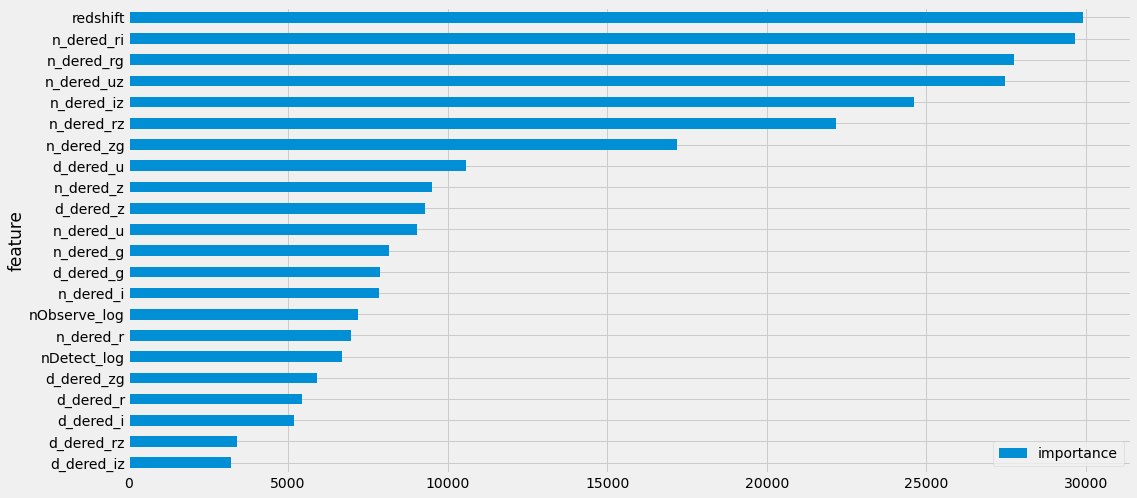

In [43]:
imp = pd.DataFrame({'feature': df[cols_to_use].columns, 'importance': lgb_clf0.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [45]:
#pval ptst
algo_name = 'lgbm1'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst0, fmt='%.6f', delimiter=',')

HyperOptuna - cols that performs well in XGBoost

In [46]:
train = pd.read_csv(trn_file)
test = pd.read_csv(tst_file)
feature= pd.concat([train,test], axis =0)
feature.fillna(-1, inplace=True)

In [47]:
df = make_col(feature)
trn = make_col(train)

In [48]:
#Normal
X = trn[cols_to_use_best]
y = trn[target_col]

In [49]:
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=.2, random_state=seed)

In [50]:
params = {
    "objective": "multiclass",
    "n_estimators": 1000,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "num_leaves": hp.choice("num_leaves", [127 ,196, 220 ,256]),
    "colsample_bytree": hp.quniform("colsample_bytree", .5, .9, 0.1),
    "subsample": hp.quniform("subsample", .8, 1.0, 0.05),
    "min_child_samples": hp.choice('min_child_samples', [10, 15, 20, 25, 30])
}

In [51]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",
              early_stopping_rounds=30,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

100%|██████████| 10/10 [03:35<00:00, 21.51s/trial, best loss: 0.15577961380252375]
{'objective': 'multiclass', 'n_estimators': 1000, 'subsample_freq': 1, 'random_state': 8, 'n_jobs': -1, 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.0155909813664049, 'min_child_samples': 25, 'num_leaves': 220, 'subsample': 0.9500000000000001}


In [52]:
y = df[target_col].values[:320000]
trn = df[cols_to_use_best].iloc[:320000].values
tst = df[cols_to_use_best].iloc[320000:].values
feature_name = df[cols_to_use_best].columns.tolist()

In [53]:
import lightgbm as lgb
p_val = np.zeros((trn.shape[0], n_class))
p_tst1 = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    lgb_clf1 = lgb.LGBMClassifier(**params)
    lgb_clf1.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            early_stopping_rounds=30)
    
    p_val[i_val, :] = lgb_clf1.predict_proba(trn[i_val])
    p_tst1 += lgb_clf1.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.965153
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 0.943826
[3]	valid_0's multi_logloss: 0.925895
[4]	valid_0's multi_logloss: 0.906185
[5]	valid_0's multi_logloss: 0.887471
[6]	valid_0's multi_logloss: 0.869514
[7]	valid_0's multi_logloss: 0.853575
[8]	valid_0's multi_logloss: 0.835643
[9]	valid_0's multi_logloss: 0.81917
[10]	valid_0's multi_logloss: 0.803312
[11]	valid_0's multi_logloss: 0.786781
[12]	valid_0's multi_logloss: 0.771276
[13]	valid_0's multi_logloss: 0.756765
[14]	valid_0's multi_logloss: 0.742753
[15]	valid_0's multi_logloss: 0.73023
[16]	valid_0's multi_logloss: 0.716443
[17]	valid_0's multi_logloss: 0.703625
[18]	valid_0's multi_logloss: 0.690425
[19]	valid_0's multi_logloss: 0.679333
[20]	valid_0's multi_logloss: 0.66761
[21]	valid_0's multi_logloss: 0.65751
[22]	valid_0's multi_logloss: 0.646702
[23]	valid_0's multi_logloss: 0.635551
[24]	valid_0's multi_logloss: 

[207]	valid_0's multi_logloss: 0.181316
[208]	valid_0's multi_logloss: 0.180932
[209]	valid_0's multi_logloss: 0.180612
[210]	valid_0's multi_logloss: 0.180376
[211]	valid_0's multi_logloss: 0.180027
[212]	valid_0's multi_logloss: 0.179761
[213]	valid_0's multi_logloss: 0.179574
[214]	valid_0's multi_logloss: 0.179304
[215]	valid_0's multi_logloss: 0.179049
[216]	valid_0's multi_logloss: 0.178877
[217]	valid_0's multi_logloss: 0.178602
[218]	valid_0's multi_logloss: 0.178373
[219]	valid_0's multi_logloss: 0.178165
[220]	valid_0's multi_logloss: 0.177838
[221]	valid_0's multi_logloss: 0.177542
[222]	valid_0's multi_logloss: 0.177259
[223]	valid_0's multi_logloss: 0.1771
[224]	valid_0's multi_logloss: 0.176825
[225]	valid_0's multi_logloss: 0.176633
[226]	valid_0's multi_logloss: 0.17646
[227]	valid_0's multi_logloss: 0.176183
[228]	valid_0's multi_logloss: 0.17598
[229]	valid_0's multi_logloss: 0.175697
[230]	valid_0's multi_logloss: 0.175479
[231]	valid_0's multi_logloss: 0.175326
[232

[414]	valid_0's multi_logloss: 0.159612
[415]	valid_0's multi_logloss: 0.15959
[416]	valid_0's multi_logloss: 0.15956
[417]	valid_0's multi_logloss: 0.159531
[418]	valid_0's multi_logloss: 0.159501
[419]	valid_0's multi_logloss: 0.159483
[420]	valid_0's multi_logloss: 0.159456
[421]	valid_0's multi_logloss: 0.159435
[422]	valid_0's multi_logloss: 0.159411
[423]	valid_0's multi_logloss: 0.15938
[424]	valid_0's multi_logloss: 0.159347
[425]	valid_0's multi_logloss: 0.159318
[426]	valid_0's multi_logloss: 0.159286
[427]	valid_0's multi_logloss: 0.159264
[428]	valid_0's multi_logloss: 0.159244
[429]	valid_0's multi_logloss: 0.159221
[430]	valid_0's multi_logloss: 0.159187
[431]	valid_0's multi_logloss: 0.15917
[432]	valid_0's multi_logloss: 0.159144
[433]	valid_0's multi_logloss: 0.15912
[434]	valid_0's multi_logloss: 0.159102
[435]	valid_0's multi_logloss: 0.159082
[436]	valid_0's multi_logloss: 0.159058
[437]	valid_0's multi_logloss: 0.159048
[438]	valid_0's multi_logloss: 0.15903
[439]	

[623]	valid_0's multi_logloss: 0.157233
[624]	valid_0's multi_logloss: 0.157223
[625]	valid_0's multi_logloss: 0.157219
[626]	valid_0's multi_logloss: 0.157215
[627]	valid_0's multi_logloss: 0.157209
[628]	valid_0's multi_logloss: 0.157206
[629]	valid_0's multi_logloss: 0.157203
[630]	valid_0's multi_logloss: 0.157198
[631]	valid_0's multi_logloss: 0.157192
[632]	valid_0's multi_logloss: 0.157197
[633]	valid_0's multi_logloss: 0.157193
[634]	valid_0's multi_logloss: 0.157188
[635]	valid_0's multi_logloss: 0.157182
[636]	valid_0's multi_logloss: 0.157175
[637]	valid_0's multi_logloss: 0.157175
[638]	valid_0's multi_logloss: 0.157175
[639]	valid_0's multi_logloss: 0.157179
[640]	valid_0's multi_logloss: 0.157179
[641]	valid_0's multi_logloss: 0.157177
[642]	valid_0's multi_logloss: 0.157175
[643]	valid_0's multi_logloss: 0.157171
[644]	valid_0's multi_logloss: 0.15717
[645]	valid_0's multi_logloss: 0.157172
[646]	valid_0's multi_logloss: 0.157171
[647]	valid_0's multi_logloss: 0.157172
[

[69]	valid_0's multi_logloss: 0.352864
[70]	valid_0's multi_logloss: 0.349929
[71]	valid_0's multi_logloss: 0.346857
[72]	valid_0's multi_logloss: 0.343358
[73]	valid_0's multi_logloss: 0.340413
[74]	valid_0's multi_logloss: 0.336851
[75]	valid_0's multi_logloss: 0.333873
[76]	valid_0's multi_logloss: 0.330774
[77]	valid_0's multi_logloss: 0.327771
[78]	valid_0's multi_logloss: 0.324532
[79]	valid_0's multi_logloss: 0.321699
[80]	valid_0's multi_logloss: 0.318613
[81]	valid_0's multi_logloss: 0.315566
[82]	valid_0's multi_logloss: 0.312577
[83]	valid_0's multi_logloss: 0.309669
[84]	valid_0's multi_logloss: 0.30703
[85]	valid_0's multi_logloss: 0.304658
[86]	valid_0's multi_logloss: 0.302026
[87]	valid_0's multi_logloss: 0.299682
[88]	valid_0's multi_logloss: 0.297259
[89]	valid_0's multi_logloss: 0.294936
[90]	valid_0's multi_logloss: 0.292862
[91]	valid_0's multi_logloss: 0.290472
[92]	valid_0's multi_logloss: 0.288286
[93]	valid_0's multi_logloss: 0.28616
[94]	valid_0's multi_loglos

[276]	valid_0's multi_logloss: 0.171042
[277]	valid_0's multi_logloss: 0.170916
[278]	valid_0's multi_logloss: 0.170794
[279]	valid_0's multi_logloss: 0.170693
[280]	valid_0's multi_logloss: 0.170595
[281]	valid_0's multi_logloss: 0.170459
[282]	valid_0's multi_logloss: 0.170315
[283]	valid_0's multi_logloss: 0.170177
[284]	valid_0's multi_logloss: 0.170083
[285]	valid_0's multi_logloss: 0.169979
[286]	valid_0's multi_logloss: 0.169876
[287]	valid_0's multi_logloss: 0.169764
[288]	valid_0's multi_logloss: 0.169705
[289]	valid_0's multi_logloss: 0.169591
[290]	valid_0's multi_logloss: 0.169468
[291]	valid_0's multi_logloss: 0.169354
[292]	valid_0's multi_logloss: 0.16928
[293]	valid_0's multi_logloss: 0.169184
[294]	valid_0's multi_logloss: 0.169059
[295]	valid_0's multi_logloss: 0.16897
[296]	valid_0's multi_logloss: 0.168861
[297]	valid_0's multi_logloss: 0.168767
[298]	valid_0's multi_logloss: 0.168645
[299]	valid_0's multi_logloss: 0.168538
[300]	valid_0's multi_logloss: 0.168439
[3

[482]	valid_0's multi_logloss: 0.161495
[483]	valid_0's multi_logloss: 0.161484
[484]	valid_0's multi_logloss: 0.161478
[485]	valid_0's multi_logloss: 0.161466
[486]	valid_0's multi_logloss: 0.161453
[487]	valid_0's multi_logloss: 0.161444
[488]	valid_0's multi_logloss: 0.161439
[489]	valid_0's multi_logloss: 0.16143
[490]	valid_0's multi_logloss: 0.161418
[491]	valid_0's multi_logloss: 0.161407
[492]	valid_0's multi_logloss: 0.1614
[493]	valid_0's multi_logloss: 0.161383
[494]	valid_0's multi_logloss: 0.161358
[495]	valid_0's multi_logloss: 0.161341
[496]	valid_0's multi_logloss: 0.161331
[497]	valid_0's multi_logloss: 0.161322
[498]	valid_0's multi_logloss: 0.161313
[499]	valid_0's multi_logloss: 0.161305
[500]	valid_0's multi_logloss: 0.1613
[501]	valid_0's multi_logloss: 0.161282
[502]	valid_0's multi_logloss: 0.161265
[503]	valid_0's multi_logloss: 0.161255
[504]	valid_0's multi_logloss: 0.161243
[505]	valid_0's multi_logloss: 0.161234
[506]	valid_0's multi_logloss: 0.16123
[507]	

[688]	valid_0's multi_logloss: 0.16048
[689]	valid_0's multi_logloss: 0.160483
[690]	valid_0's multi_logloss: 0.160479
[691]	valid_0's multi_logloss: 0.160474
[692]	valid_0's multi_logloss: 0.160468
[693]	valid_0's multi_logloss: 0.160468
[694]	valid_0's multi_logloss: 0.160467
[695]	valid_0's multi_logloss: 0.160469
[696]	valid_0's multi_logloss: 0.16046
[697]	valid_0's multi_logloss: 0.160466
[698]	valid_0's multi_logloss: 0.160469
[699]	valid_0's multi_logloss: 0.16047
[700]	valid_0's multi_logloss: 0.160471
[701]	valid_0's multi_logloss: 0.160478
[702]	valid_0's multi_logloss: 0.160472
[703]	valid_0's multi_logloss: 0.160471
[704]	valid_0's multi_logloss: 0.160479
[705]	valid_0's multi_logloss: 0.160473
[706]	valid_0's multi_logloss: 0.160469
[707]	valid_0's multi_logloss: 0.160468
[708]	valid_0's multi_logloss: 0.160465
[709]	valid_0's multi_logloss: 0.160469
[710]	valid_0's multi_logloss: 0.160468
[711]	valid_0's multi_logloss: 0.160472
[712]	valid_0's multi_logloss: 0.160475
[71

[167]	valid_0's multi_logloss: 0.198997
[168]	valid_0's multi_logloss: 0.198547
[169]	valid_0's multi_logloss: 0.197924
[170]	valid_0's multi_logloss: 0.197341
[171]	valid_0's multi_logloss: 0.196679
[172]	valid_0's multi_logloss: 0.19607
[173]	valid_0's multi_logloss: 0.195556
[174]	valid_0's multi_logloss: 0.195026
[175]	valid_0's multi_logloss: 0.194539
[176]	valid_0's multi_logloss: 0.194156
[177]	valid_0's multi_logloss: 0.193738
[178]	valid_0's multi_logloss: 0.193273
[179]	valid_0's multi_logloss: 0.192767
[180]	valid_0's multi_logloss: 0.192348
[181]	valid_0's multi_logloss: 0.191914
[182]	valid_0's multi_logloss: 0.191481
[183]	valid_0's multi_logloss: 0.190923
[184]	valid_0's multi_logloss: 0.19065
[185]	valid_0's multi_logloss: 0.190138
[186]	valid_0's multi_logloss: 0.189619
[187]	valid_0's multi_logloss: 0.18918
[188]	valid_0's multi_logloss: 0.188676
[189]	valid_0's multi_logloss: 0.188257
[190]	valid_0's multi_logloss: 0.187906
[191]	valid_0's multi_logloss: 0.187555
[19

[376]	valid_0's multi_logloss: 0.161695
[377]	valid_0's multi_logloss: 0.161661
[378]	valid_0's multi_logloss: 0.16162
[379]	valid_0's multi_logloss: 0.1616
[380]	valid_0's multi_logloss: 0.161574
[381]	valid_0's multi_logloss: 0.161528
[382]	valid_0's multi_logloss: 0.161507
[383]	valid_0's multi_logloss: 0.161462
[384]	valid_0's multi_logloss: 0.16142
[385]	valid_0's multi_logloss: 0.161376
[386]	valid_0's multi_logloss: 0.161338
[387]	valid_0's multi_logloss: 0.1613
[388]	valid_0's multi_logloss: 0.16126
[389]	valid_0's multi_logloss: 0.16123
[390]	valid_0's multi_logloss: 0.161194
[391]	valid_0's multi_logloss: 0.16117
[392]	valid_0's multi_logloss: 0.161142
[393]	valid_0's multi_logloss: 0.161102
[394]	valid_0's multi_logloss: 0.161058
[395]	valid_0's multi_logloss: 0.161024
[396]	valid_0's multi_logloss: 0.160997
[397]	valid_0's multi_logloss: 0.160974
[398]	valid_0's multi_logloss: 0.160945
[399]	valid_0's multi_logloss: 0.160914
[400]	valid_0's multi_logloss: 0.160877
[401]	val

[583]	valid_0's multi_logloss: 0.158435
[584]	valid_0's multi_logloss: 0.158436
[585]	valid_0's multi_logloss: 0.158424
[586]	valid_0's multi_logloss: 0.158413
[587]	valid_0's multi_logloss: 0.158404
[588]	valid_0's multi_logloss: 0.158393
[589]	valid_0's multi_logloss: 0.15839
[590]	valid_0's multi_logloss: 0.158376
[591]	valid_0's multi_logloss: 0.158368
[592]	valid_0's multi_logloss: 0.158361
[593]	valid_0's multi_logloss: 0.158354
[594]	valid_0's multi_logloss: 0.158352
[595]	valid_0's multi_logloss: 0.158345
[596]	valid_0's multi_logloss: 0.158342
[597]	valid_0's multi_logloss: 0.158334
[598]	valid_0's multi_logloss: 0.15833
[599]	valid_0's multi_logloss: 0.158322
[600]	valid_0's multi_logloss: 0.158321
[601]	valid_0's multi_logloss: 0.158322
[602]	valid_0's multi_logloss: 0.158324
[603]	valid_0's multi_logloss: 0.158318
[604]	valid_0's multi_logloss: 0.158321
[605]	valid_0's multi_logloss: 0.158323
[606]	valid_0's multi_logloss: 0.158325
[607]	valid_0's multi_logloss: 0.158319
[6

training model for CV #4
[1]	valid_0's multi_logloss: 0.965152
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 0.943846
[3]	valid_0's multi_logloss: 0.925921
[4]	valid_0's multi_logloss: 0.90621
[5]	valid_0's multi_logloss: 0.887446
[6]	valid_0's multi_logloss: 0.869487
[7]	valid_0's multi_logloss: 0.853545
[8]	valid_0's multi_logloss: 0.835586
[9]	valid_0's multi_logloss: 0.819149
[10]	valid_0's multi_logloss: 0.803298
[11]	valid_0's multi_logloss: 0.786769
[12]	valid_0's multi_logloss: 0.771282
[13]	valid_0's multi_logloss: 0.75676
[14]	valid_0's multi_logloss: 0.742749
[15]	valid_0's multi_logloss: 0.730273
[16]	valid_0's multi_logloss: 0.716458
[17]	valid_0's multi_logloss: 0.703657
[18]	valid_0's multi_logloss: 0.69046
[19]	valid_0's multi_logloss: 0.679316
[20]	valid_0's multi_logloss: 0.667623
[21]	valid_0's multi_logloss: 0.657517
[22]	valid_0's multi_logloss: 0.646827
[23]	valid_0's multi_logloss: 0.635681
[24]	valid_0's multi_logloss:

[209]	valid_0's multi_logloss: 0.180711
[210]	valid_0's multi_logloss: 0.18046
[211]	valid_0's multi_logloss: 0.180117
[212]	valid_0's multi_logloss: 0.179859
[213]	valid_0's multi_logloss: 0.179682
[214]	valid_0's multi_logloss: 0.179419
[215]	valid_0's multi_logloss: 0.179172
[216]	valid_0's multi_logloss: 0.179009
[217]	valid_0's multi_logloss: 0.178708
[218]	valid_0's multi_logloss: 0.178498
[219]	valid_0's multi_logloss: 0.178292
[220]	valid_0's multi_logloss: 0.177982
[221]	valid_0's multi_logloss: 0.177672
[222]	valid_0's multi_logloss: 0.177393
[223]	valid_0's multi_logloss: 0.177231
[224]	valid_0's multi_logloss: 0.176955
[225]	valid_0's multi_logloss: 0.176774
[226]	valid_0's multi_logloss: 0.176602
[227]	valid_0's multi_logloss: 0.176318
[228]	valid_0's multi_logloss: 0.176106
[229]	valid_0's multi_logloss: 0.175822
[230]	valid_0's multi_logloss: 0.175615
[231]	valid_0's multi_logloss: 0.175459
[232]	valid_0's multi_logloss: 0.175207
[233]	valid_0's multi_logloss: 0.175018
[

[416]	valid_0's multi_logloss: 0.160062
[417]	valid_0's multi_logloss: 0.160032
[418]	valid_0's multi_logloss: 0.160009
[419]	valid_0's multi_logloss: 0.159994
[420]	valid_0's multi_logloss: 0.15997
[421]	valid_0's multi_logloss: 0.159952
[422]	valid_0's multi_logloss: 0.159935
[423]	valid_0's multi_logloss: 0.159914
[424]	valid_0's multi_logloss: 0.159895
[425]	valid_0's multi_logloss: 0.159868
[426]	valid_0's multi_logloss: 0.15984
[427]	valid_0's multi_logloss: 0.159815
[428]	valid_0's multi_logloss: 0.159792
[429]	valid_0's multi_logloss: 0.159774
[430]	valid_0's multi_logloss: 0.159745
[431]	valid_0's multi_logloss: 0.159741
[432]	valid_0's multi_logloss: 0.159707
[433]	valid_0's multi_logloss: 0.159686
[434]	valid_0's multi_logloss: 0.159671
[435]	valid_0's multi_logloss: 0.159656
[436]	valid_0's multi_logloss: 0.159642
[437]	valid_0's multi_logloss: 0.159624
[438]	valid_0's multi_logloss: 0.159608
[439]	valid_0's multi_logloss: 0.1596
[440]	valid_0's multi_logloss: 0.159583
[441

[623]	valid_0's multi_logloss: 0.158104
[624]	valid_0's multi_logloss: 0.158106
[625]	valid_0's multi_logloss: 0.158107
[626]	valid_0's multi_logloss: 0.158108
[627]	valid_0's multi_logloss: 0.158108
[628]	valid_0's multi_logloss: 0.158108
[629]	valid_0's multi_logloss: 0.158108
[630]	valid_0's multi_logloss: 0.158101
[631]	valid_0's multi_logloss: 0.158106
[632]	valid_0's multi_logloss: 0.158106
[633]	valid_0's multi_logloss: 0.158103
[634]	valid_0's multi_logloss: 0.158107
[635]	valid_0's multi_logloss: 0.158103
[636]	valid_0's multi_logloss: 0.158098
[637]	valid_0's multi_logloss: 0.158096
[638]	valid_0's multi_logloss: 0.158094
[639]	valid_0's multi_logloss: 0.158087
[640]	valid_0's multi_logloss: 0.158079
[641]	valid_0's multi_logloss: 0.15807
[642]	valid_0's multi_logloss: 0.158065
[643]	valid_0's multi_logloss: 0.158069
[644]	valid_0's multi_logloss: 0.158065
[645]	valid_0's multi_logloss: 0.158063
[646]	valid_0's multi_logloss: 0.15806
[647]	valid_0's multi_logloss: 0.158056
[6

[136]	valid_0's multi_logloss: 0.219025
[137]	valid_0's multi_logloss: 0.218147
[138]	valid_0's multi_logloss: 0.217127
[139]	valid_0's multi_logloss: 0.216277
[140]	valid_0's multi_logloss: 0.215232
[141]	valid_0's multi_logloss: 0.214429
[142]	valid_0's multi_logloss: 0.21356
[143]	valid_0's multi_logloss: 0.212875
[144]	valid_0's multi_logloss: 0.212106
[145]	valid_0's multi_logloss: 0.211106
[146]	valid_0's multi_logloss: 0.210288
[147]	valid_0's multi_logloss: 0.209452
[148]	valid_0's multi_logloss: 0.208647
[149]	valid_0's multi_logloss: 0.20794
[150]	valid_0's multi_logloss: 0.207036
[151]	valid_0's multi_logloss: 0.206296
[152]	valid_0's multi_logloss: 0.205617
[153]	valid_0's multi_logloss: 0.204961
[154]	valid_0's multi_logloss: 0.204205
[155]	valid_0's multi_logloss: 0.203417
[156]	valid_0's multi_logloss: 0.202781
[157]	valid_0's multi_logloss: 0.202126
[158]	valid_0's multi_logloss: 0.201362
[159]	valid_0's multi_logloss: 0.200704
[160]	valid_0's multi_logloss: 0.200208
[1

[344]	valid_0's multi_logloss: 0.159403
[345]	valid_0's multi_logloss: 0.159357
[346]	valid_0's multi_logloss: 0.159295
[347]	valid_0's multi_logloss: 0.159236
[348]	valid_0's multi_logloss: 0.159204
[349]	valid_0's multi_logloss: 0.159158
[350]	valid_0's multi_logloss: 0.159124
[351]	valid_0's multi_logloss: 0.159055
[352]	valid_0's multi_logloss: 0.158993
[353]	valid_0's multi_logloss: 0.15895
[354]	valid_0's multi_logloss: 0.158918
[355]	valid_0's multi_logloss: 0.158865
[356]	valid_0's multi_logloss: 0.158809
[357]	valid_0's multi_logloss: 0.158748
[358]	valid_0's multi_logloss: 0.15871
[359]	valid_0's multi_logloss: 0.15866
[360]	valid_0's multi_logloss: 0.1586
[361]	valid_0's multi_logloss: 0.158536
[362]	valid_0's multi_logloss: 0.158492
[363]	valid_0's multi_logloss: 0.158451
[364]	valid_0's multi_logloss: 0.158406
[365]	valid_0's multi_logloss: 0.158387
[366]	valid_0's multi_logloss: 0.15835
[367]	valid_0's multi_logloss: 0.158306
[368]	valid_0's multi_logloss: 0.158263
[369]	

[551]	valid_0's multi_logloss: 0.154856
[552]	valid_0's multi_logloss: 0.154851
[553]	valid_0's multi_logloss: 0.154847
[554]	valid_0's multi_logloss: 0.154837
[555]	valid_0's multi_logloss: 0.154835
[556]	valid_0's multi_logloss: 0.154831
[557]	valid_0's multi_logloss: 0.15481
[558]	valid_0's multi_logloss: 0.154804
[559]	valid_0's multi_logloss: 0.154792
[560]	valid_0's multi_logloss: 0.15479
[561]	valid_0's multi_logloss: 0.154782
[562]	valid_0's multi_logloss: 0.154772
[563]	valid_0's multi_logloss: 0.15477
[564]	valid_0's multi_logloss: 0.154762
[565]	valid_0's multi_logloss: 0.154761
[566]	valid_0's multi_logloss: 0.154751
[567]	valid_0's multi_logloss: 0.154745
[568]	valid_0's multi_logloss: 0.154745
[569]	valid_0's multi_logloss: 0.154746
[570]	valid_0's multi_logloss: 0.154742
[571]	valid_0's multi_logloss: 0.154739
[572]	valid_0's multi_logloss: 0.154729
[573]	valid_0's multi_logloss: 0.154722
[574]	valid_0's multi_logloss: 0.154721
[575]	valid_0's multi_logloss: 0.154711
[57

In [54]:
print(f'{accuracy_score(y,np.argmax(p_val,axis =1))*100:.4f}%')

93.4166%


In [55]:
sub = submission
sub.head()

,id,class
0,320000,0
1,320001,0
2,320002,0
3,320003,0
4,320004,0


In [56]:
np.argmax(p_tst1,axis =1).shape
sub[target_col] = np.argmax(p_tst1, axis=1)
sub.head()

,id,class
0,320000,2
1,320001,0
2,320002,2
3,320003,0
4,320004,2


In [57]:
sub[target_col].value_counts()

2    40822
0    29975
1     9203
Name: class, dtype: int64

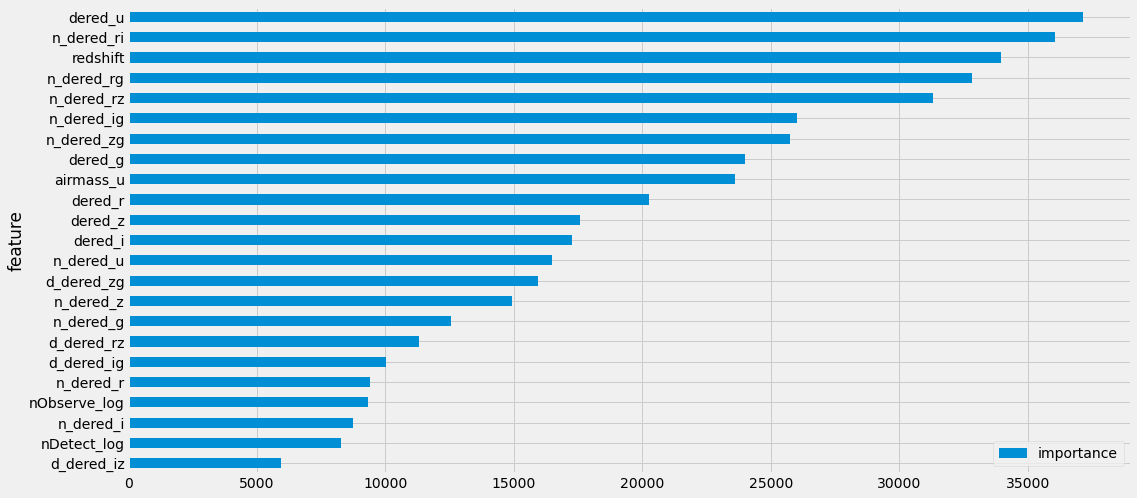

In [58]:
imp = pd.DataFrame({'feature': df[cols_to_use_best].columns, 'importance': lgb_clf1.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [60]:
#pval ptst
algo_name = 'lgbm2'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst1, fmt='%.6f', delimiter=',')

lgbm3) cols_clean

In [61]:
train = pd.read_csv(trn_file)
test = pd.read_csv(tst_file)
feature= pd.concat([train,test], axis =0)
feature.fillna(-1, inplace=True)

In [62]:
df = make_col(feature)
trn = make_col(train)

In [63]:
cols_to_use_clean = ['u',
 'g',
 'r',
 'i',
 'z',
 'redshift',
 'dered_u',
 'dered_g',
 'dered_r',
 'dered_i',
 'dered_z',
 'airmass_u',
 'nObserve_log',
 'nDetect_log',
 'd_dered_u',
 'd_dered_g',
 'd_dered_r',
 'd_dered_i',
 'd_dered_z',
 'd_dered_ig',
 'd_dered_zg',
 'd_dered_rz',
 'd_dered_iz',
 'd_obs_det']

In [64]:
#Normal
X = trn[cols_to_use_clean]
y = trn[target_col]

In [65]:
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=.1, random_state=seed)

In [66]:
params = {
    "objective": "multiclass",
    "n_estimators": 1500,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
    "num_leaves": hp.choice("num_leaves", [127 ,196, 220 ,256 , 280]),
    "colsample_bytree": hp.quniform("colsample_bytree", .5, 1.0, 0.1),
    "subsample": hp.quniform("subsample", .8, 1.0, 0.05),
    "min_child_samples": hp.choice('min_child_samples', np.linspace(10, 200, 5, dtype=int)),
    
    "bagging_fraction": hp.quniform("bagging_fraction", 0.5, 1.0, 0.1),
    "bagging_freq": hp.choice("bagging_freq", np.linspace(0, 50, 10, dtype=int))
}

In [67]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",
              early_stopping_rounds=30,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

[LightGBM] [Warning]                                  
bagging_fraction is set=1.0, subsample=0.8 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning]                                  
bagging_freq is set=11, subsample_freq=1 will be ignored. Current value: bagging_freq=11
100%|██████████| 10/10 [05:00<00:00, 30.01s/trial, best loss: 0.1679568977542666]
{'objective': 'multiclass', 'n_estimators': 1500, 'subsample_freq': 1, 'random_state': 8, 'n_jobs': -1, 'bagging_fraction': 1.0, 'bagging_freq': 38, 'colsample_bytree': 0.8, 'learning_rate': 0.01447051963130137, 'min_child_samples': 105, 'num_leaves': 256, 'subsample': 0.9}


In [68]:
y = df[target_col].values[:320000]
trn = df[cols_to_use_clean].iloc[:320000].values
tst = df[cols_to_use_clean].iloc[320000:].values
feature_name = df[cols_to_use_clean].columns.tolist()

In [70]:
import lightgbm as lgb
p_val = np.zeros((trn.shape[0], n_class))
p_tst2 = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    lgb_clf2 = lgb.LGBMClassifier(**params)
    lgb_clf2.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            early_stopping_rounds=30)
    
    p_val[i_val, :] = lgb_clf2.predict_proba(trn[i_val])
    p_tst2 += lgb_clf2.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.964984
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 0.944714
[3]	valid_0's multi_logloss: 0.925332
[4]	valid_0's multi_logloss: 0.906532
[5]	valid_0's multi_logloss: 0.889601
[6]	valid_0's multi_logloss: 0.87204
[7]	valid_0's multi_logloss: 0.856273
[8]	valid_0's multi_logloss: 0.839902
[9]	valid_0's multi_logloss: 0.825956
[10]	valid_0's multi_logloss: 0.810566
[11]	valid_0's multi_logloss: 0.79573
[12]	valid_0's multi_logloss: 0.78311
[13]	valid_0's multi_logloss: 0.770729
[14]	valid_0's multi_logloss: 0.759496
[15]	valid_0's multi_logloss: 0.747918
[16]	valid_0's multi_logloss: 0.734962
[17]	valid_0's multi_logloss: 0.722384
[18]	valid_0's multi_logloss: 0.71014
[19]	valid_0's multi_logloss: 0.69828
[20]	valid_0's multi_logloss: 0.687319
[21]	valid_0's multi_logloss: 0.67605
[22]	valid_0's multi_logloss: 0.665702
[23]	valid_0's multi_logloss: 0.655886
[24]	valid_0's multi_logloss: 0.

[208]	valid_0's multi_logloss: 0.202517
[209]	valid_0's multi_logloss: 0.202176
[210]	valid_0's multi_logloss: 0.201824
[211]	valid_0's multi_logloss: 0.201604
[212]	valid_0's multi_logloss: 0.201253
[213]	valid_0's multi_logloss: 0.200894
[214]	valid_0's multi_logloss: 0.200674
[215]	valid_0's multi_logloss: 0.200313
[216]	valid_0's multi_logloss: 0.200012
[217]	valid_0's multi_logloss: 0.199729
[218]	valid_0's multi_logloss: 0.19952
[219]	valid_0's multi_logloss: 0.199198
[220]	valid_0's multi_logloss: 0.198874
[221]	valid_0's multi_logloss: 0.198561
[222]	valid_0's multi_logloss: 0.198322
[223]	valid_0's multi_logloss: 0.198079
[224]	valid_0's multi_logloss: 0.197775
[225]	valid_0's multi_logloss: 0.197556
[226]	valid_0's multi_logloss: 0.197251
[227]	valid_0's multi_logloss: 0.19696
[228]	valid_0's multi_logloss: 0.196671
[229]	valid_0's multi_logloss: 0.196506
[230]	valid_0's multi_logloss: 0.19629
[231]	valid_0's multi_logloss: 0.196022
[232]	valid_0's multi_logloss: 0.195746
[23

[415]	valid_0's multi_logloss: 0.176378
[416]	valid_0's multi_logloss: 0.176324
[417]	valid_0's multi_logloss: 0.176264
[418]	valid_0's multi_logloss: 0.176233
[419]	valid_0's multi_logloss: 0.176204
[420]	valid_0's multi_logloss: 0.176167
[421]	valid_0's multi_logloss: 0.176121
[422]	valid_0's multi_logloss: 0.176085
[423]	valid_0's multi_logloss: 0.17607
[424]	valid_0's multi_logloss: 0.176042
[425]	valid_0's multi_logloss: 0.176004
[426]	valid_0's multi_logloss: 0.175967
[427]	valid_0's multi_logloss: 0.175912
[428]	valid_0's multi_logloss: 0.175865
[429]	valid_0's multi_logloss: 0.175841
[430]	valid_0's multi_logloss: 0.175819
[431]	valid_0's multi_logloss: 0.175792
[432]	valid_0's multi_logloss: 0.175779
[433]	valid_0's multi_logloss: 0.175747
[434]	valid_0's multi_logloss: 0.175717
[435]	valid_0's multi_logloss: 0.175691
[436]	valid_0's multi_logloss: 0.175662
[437]	valid_0's multi_logloss: 0.175629
[438]	valid_0's multi_logloss: 0.175593
[439]	valid_0's multi_logloss: 0.175565
[

[623]	valid_0's multi_logloss: 0.172548
[624]	valid_0's multi_logloss: 0.172538
[625]	valid_0's multi_logloss: 0.172528
[626]	valid_0's multi_logloss: 0.172521
[627]	valid_0's multi_logloss: 0.17252
[628]	valid_0's multi_logloss: 0.172516
[629]	valid_0's multi_logloss: 0.172514
[630]	valid_0's multi_logloss: 0.172505
[631]	valid_0's multi_logloss: 0.172492
[632]	valid_0's multi_logloss: 0.172476
[633]	valid_0's multi_logloss: 0.172472
[634]	valid_0's multi_logloss: 0.172466
[635]	valid_0's multi_logloss: 0.172463
[636]	valid_0's multi_logloss: 0.172454
[637]	valid_0's multi_logloss: 0.172455
[638]	valid_0's multi_logloss: 0.172447
[639]	valid_0's multi_logloss: 0.172449
[640]	valid_0's multi_logloss: 0.172445
[641]	valid_0's multi_logloss: 0.172443
[642]	valid_0's multi_logloss: 0.172437
[643]	valid_0's multi_logloss: 0.172436
[644]	valid_0's multi_logloss: 0.172434
[645]	valid_0's multi_logloss: 0.172439
[646]	valid_0's multi_logloss: 0.172437
[647]	valid_0's multi_logloss: 0.172432
[

[831]	valid_0's multi_logloss: 0.171861
[832]	valid_0's multi_logloss: 0.171861
[833]	valid_0's multi_logloss: 0.171861
[834]	valid_0's multi_logloss: 0.17186
[835]	valid_0's multi_logloss: 0.171867
[836]	valid_0's multi_logloss: 0.17187
[837]	valid_0's multi_logloss: 0.171877
[838]	valid_0's multi_logloss: 0.17188
[839]	valid_0's multi_logloss: 0.171886
[840]	valid_0's multi_logloss: 0.171878
[841]	valid_0's multi_logloss: 0.171882
[842]	valid_0's multi_logloss: 0.171889
[843]	valid_0's multi_logloss: 0.171885
[844]	valid_0's multi_logloss: 0.17188
[845]	valid_0's multi_logloss: 0.171879
[846]	valid_0's multi_logloss: 0.171872
[847]	valid_0's multi_logloss: 0.171871
[848]	valid_0's multi_logloss: 0.171876
[849]	valid_0's multi_logloss: 0.171872
[850]	valid_0's multi_logloss: 0.171873
[851]	valid_0's multi_logloss: 0.171872
[852]	valid_0's multi_logloss: 0.171873
[853]	valid_0's multi_logloss: 0.171878
[854]	valid_0's multi_logloss: 0.171882
[855]	valid_0's multi_logloss: 0.171873
[856

[170]	valid_0's multi_logloss: 0.221293
[171]	valid_0's multi_logloss: 0.220629
[172]	valid_0's multi_logloss: 0.22001
[173]	valid_0's multi_logloss: 0.219518
[174]	valid_0's multi_logloss: 0.218943
[175]	valid_0's multi_logloss: 0.21833
[176]	valid_0's multi_logloss: 0.217756
[177]	valid_0's multi_logloss: 0.217172
[178]	valid_0's multi_logloss: 0.216694
[179]	valid_0's multi_logloss: 0.216119
[180]	valid_0's multi_logloss: 0.215721
[181]	valid_0's multi_logloss: 0.215217
[182]	valid_0's multi_logloss: 0.214661
[183]	valid_0's multi_logloss: 0.214359
[184]	valid_0's multi_logloss: 0.214032
[185]	valid_0's multi_logloss: 0.213491
[186]	valid_0's multi_logloss: 0.213023
[187]	valid_0's multi_logloss: 0.212529
[188]	valid_0's multi_logloss: 0.212017
[189]	valid_0's multi_logloss: 0.211724
[190]	valid_0's multi_logloss: 0.211219
[191]	valid_0's multi_logloss: 0.210763
[192]	valid_0's multi_logloss: 0.210282
[193]	valid_0's multi_logloss: 0.209854
[194]	valid_0's multi_logloss: 0.209393
[1

[378]	valid_0's multi_logloss: 0.180975
[379]	valid_0's multi_logloss: 0.180926
[380]	valid_0's multi_logloss: 0.180881
[381]	valid_0's multi_logloss: 0.180805
[382]	valid_0's multi_logloss: 0.180765
[383]	valid_0's multi_logloss: 0.180727
[384]	valid_0's multi_logloss: 0.180686
[385]	valid_0's multi_logloss: 0.180646
[386]	valid_0's multi_logloss: 0.180583
[387]	valid_0's multi_logloss: 0.180553
[388]	valid_0's multi_logloss: 0.180505
[389]	valid_0's multi_logloss: 0.180464
[390]	valid_0's multi_logloss: 0.180412
[391]	valid_0's multi_logloss: 0.180377
[392]	valid_0's multi_logloss: 0.180328
[393]	valid_0's multi_logloss: 0.180294
[394]	valid_0's multi_logloss: 0.180239
[395]	valid_0's multi_logloss: 0.180176
[396]	valid_0's multi_logloss: 0.18015
[397]	valid_0's multi_logloss: 0.180115
[398]	valid_0's multi_logloss: 0.180075
[399]	valid_0's multi_logloss: 0.180027
[400]	valid_0's multi_logloss: 0.18
[401]	valid_0's multi_logloss: 0.179955
[402]	valid_0's multi_logloss: 0.179918
[403]

[586]	valid_0's multi_logloss: 0.176219
[587]	valid_0's multi_logloss: 0.176205
[588]	valid_0's multi_logloss: 0.176196
[589]	valid_0's multi_logloss: 0.176191
[590]	valid_0's multi_logloss: 0.17618
[591]	valid_0's multi_logloss: 0.176175
[592]	valid_0's multi_logloss: 0.17617
[593]	valid_0's multi_logloss: 0.176164
[594]	valid_0's multi_logloss: 0.176152
[595]	valid_0's multi_logloss: 0.176149
[596]	valid_0's multi_logloss: 0.176154
[597]	valid_0's multi_logloss: 0.176143
[598]	valid_0's multi_logloss: 0.176134
[599]	valid_0's multi_logloss: 0.176118
[600]	valid_0's multi_logloss: 0.176107
[601]	valid_0's multi_logloss: 0.176095
[602]	valid_0's multi_logloss: 0.176076
[603]	valid_0's multi_logloss: 0.176073
[604]	valid_0's multi_logloss: 0.176063
[605]	valid_0's multi_logloss: 0.176058
[606]	valid_0's multi_logloss: 0.176054
[607]	valid_0's multi_logloss: 0.17605
[608]	valid_0's multi_logloss: 0.176044
[609]	valid_0's multi_logloss: 0.176046
[610]	valid_0's multi_logloss: 0.17604
[611

[794]	valid_0's multi_logloss: 0.175591
[795]	valid_0's multi_logloss: 0.175599
[796]	valid_0's multi_logloss: 0.175597
[797]	valid_0's multi_logloss: 0.175601
[798]	valid_0's multi_logloss: 0.175601
[799]	valid_0's multi_logloss: 0.175601
[800]	valid_0's multi_logloss: 0.175608
[801]	valid_0's multi_logloss: 0.175611
[802]	valid_0's multi_logloss: 0.175612
Early stopping, best iteration is:
[772]	valid_0's multi_logloss: 0.175583
training model for CV #3
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=0.9 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=38, subsample_freq=1 will be ignored. Current value: bagging_freq=38
[1]	valid_0's multi_logloss: 0.964995
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 0.944724
[3]	valid_0's multi_logloss: 0.925382
[4]	valid_0's multi_logloss: 0.906587
[5]	valid_0's multi_logloss: 0.889709
[6]	valid_0's multi_logloss: 0.872209
[7]	valid_0's multi_logl

[193]	valid_0's multi_logloss: 0.208468
[194]	valid_0's multi_logloss: 0.208032
[195]	valid_0's multi_logloss: 0.207648
[196]	valid_0's multi_logloss: 0.207371
[197]	valid_0's multi_logloss: 0.20702
[198]	valid_0's multi_logloss: 0.206664
[199]	valid_0's multi_logloss: 0.206385
[200]	valid_0's multi_logloss: 0.205969
[201]	valid_0's multi_logloss: 0.205558
[202]	valid_0's multi_logloss: 0.205211
[203]	valid_0's multi_logloss: 0.204812
[204]	valid_0's multi_logloss: 0.204449
[205]	valid_0's multi_logloss: 0.204133
[206]	valid_0's multi_logloss: 0.203895
[207]	valid_0's multi_logloss: 0.203574
[208]	valid_0's multi_logloss: 0.203219
[209]	valid_0's multi_logloss: 0.202876
[210]	valid_0's multi_logloss: 0.202494
[211]	valid_0's multi_logloss: 0.202276
[212]	valid_0's multi_logloss: 0.201923
[213]	valid_0's multi_logloss: 0.20158
[214]	valid_0's multi_logloss: 0.201356
[215]	valid_0's multi_logloss: 0.201017
[216]	valid_0's multi_logloss: 0.200737
[217]	valid_0's multi_logloss: 0.20044
[21

[400]	valid_0's multi_logloss: 0.177845
[401]	valid_0's multi_logloss: 0.177788
[402]	valid_0's multi_logloss: 0.177756
[403]	valid_0's multi_logloss: 0.177704
[404]	valid_0's multi_logloss: 0.177653
[405]	valid_0's multi_logloss: 0.177604
[406]	valid_0's multi_logloss: 0.177551
[407]	valid_0's multi_logloss: 0.177516
[408]	valid_0's multi_logloss: 0.177489
[409]	valid_0's multi_logloss: 0.177461
[410]	valid_0's multi_logloss: 0.177424
[411]	valid_0's multi_logloss: 0.177398
[412]	valid_0's multi_logloss: 0.17736
[413]	valid_0's multi_logloss: 0.177322
[414]	valid_0's multi_logloss: 0.177292
[415]	valid_0's multi_logloss: 0.177238
[416]	valid_0's multi_logloss: 0.177194
[417]	valid_0's multi_logloss: 0.177152
[418]	valid_0's multi_logloss: 0.177117
[419]	valid_0's multi_logloss: 0.177097
[420]	valid_0's multi_logloss: 0.177044
[421]	valid_0's multi_logloss: 0.176997
[422]	valid_0's multi_logloss: 0.176974
[423]	valid_0's multi_logloss: 0.176955
[424]	valid_0's multi_logloss: 0.17692
[4

[606]	valid_0's multi_logloss: 0.173641
[607]	valid_0's multi_logloss: 0.173632
[608]	valid_0's multi_logloss: 0.173625
[609]	valid_0's multi_logloss: 0.17362
[610]	valid_0's multi_logloss: 0.173608
[611]	valid_0's multi_logloss: 0.173606
[612]	valid_0's multi_logloss: 0.173596
[613]	valid_0's multi_logloss: 0.173595
[614]	valid_0's multi_logloss: 0.173596
[615]	valid_0's multi_logloss: 0.173585
[616]	valid_0's multi_logloss: 0.173577
[617]	valid_0's multi_logloss: 0.173561
[618]	valid_0's multi_logloss: 0.173551
[619]	valid_0's multi_logloss: 0.173546
[620]	valid_0's multi_logloss: 0.173541
[621]	valid_0's multi_logloss: 0.173533
[622]	valid_0's multi_logloss: 0.173529
[623]	valid_0's multi_logloss: 0.173517
[624]	valid_0's multi_logloss: 0.173511
[625]	valid_0's multi_logloss: 0.173509
[626]	valid_0's multi_logloss: 0.173501
[627]	valid_0's multi_logloss: 0.173496
[628]	valid_0's multi_logloss: 0.173482
[629]	valid_0's multi_logloss: 0.173475
[630]	valid_0's multi_logloss: 0.173468
[

[37]	valid_0's multi_logloss: 0.538171
[38]	valid_0's multi_logloss: 0.53103
[39]	valid_0's multi_logloss: 0.524892
[40]	valid_0's multi_logloss: 0.517901
[41]	valid_0's multi_logloss: 0.511638
[42]	valid_0's multi_logloss: 0.505529
[43]	valid_0's multi_logloss: 0.499103
[44]	valid_0's multi_logloss: 0.492852
[45]	valid_0's multi_logloss: 0.486656
[46]	valid_0's multi_logloss: 0.481461
[47]	valid_0's multi_logloss: 0.475487
[48]	valid_0's multi_logloss: 0.469687
[49]	valid_0's multi_logloss: 0.464838
[50]	valid_0's multi_logloss: 0.459304
[51]	valid_0's multi_logloss: 0.453888
[52]	valid_0's multi_logloss: 0.448569
[53]	valid_0's multi_logloss: 0.443584
[54]	valid_0's multi_logloss: 0.439153
[55]	valid_0's multi_logloss: 0.434184
[56]	valid_0's multi_logloss: 0.430674
[57]	valid_0's multi_logloss: 0.425908
[58]	valid_0's multi_logloss: 0.421233
[59]	valid_0's multi_logloss: 0.416687
[60]	valid_0's multi_logloss: 0.412185
[61]	valid_0's multi_logloss: 0.408441
[62]	valid_0's multi_loglo

[244]	valid_0's multi_logloss: 0.193276
[245]	valid_0's multi_logloss: 0.193064
[246]	valid_0's multi_logloss: 0.192868
[247]	valid_0's multi_logloss: 0.192669
[248]	valid_0's multi_logloss: 0.192483
[249]	valid_0's multi_logloss: 0.192229
[250]	valid_0's multi_logloss: 0.192009
[251]	valid_0's multi_logloss: 0.191825
[252]	valid_0's multi_logloss: 0.191655
[253]	valid_0's multi_logloss: 0.191493
[254]	valid_0's multi_logloss: 0.191278
[255]	valid_0's multi_logloss: 0.191047
[256]	valid_0's multi_logloss: 0.190898
[257]	valid_0's multi_logloss: 0.190704
[258]	valid_0's multi_logloss: 0.190543
[259]	valid_0's multi_logloss: 0.190409
[260]	valid_0's multi_logloss: 0.1902
[261]	valid_0's multi_logloss: 0.190042
[262]	valid_0's multi_logloss: 0.189873
[263]	valid_0's multi_logloss: 0.189726
[264]	valid_0's multi_logloss: 0.189548
[265]	valid_0's multi_logloss: 0.189411
[266]	valid_0's multi_logloss: 0.18921
[267]	valid_0's multi_logloss: 0.189015
[268]	valid_0's multi_logloss: 0.188852
[26

[451]	valid_0's multi_logloss: 0.175783
[452]	valid_0's multi_logloss: 0.175752
[453]	valid_0's multi_logloss: 0.175719
[454]	valid_0's multi_logloss: 0.175699
[455]	valid_0's multi_logloss: 0.175676
[456]	valid_0's multi_logloss: 0.175641
[457]	valid_0's multi_logloss: 0.175615
[458]	valid_0's multi_logloss: 0.175598
[459]	valid_0's multi_logloss: 0.175575
[460]	valid_0's multi_logloss: 0.175554
[461]	valid_0's multi_logloss: 0.175542
[462]	valid_0's multi_logloss: 0.175526
[463]	valid_0's multi_logloss: 0.175511
[464]	valid_0's multi_logloss: 0.175493
[465]	valid_0's multi_logloss: 0.17546
[466]	valid_0's multi_logloss: 0.175431
[467]	valid_0's multi_logloss: 0.175411
[468]	valid_0's multi_logloss: 0.175379
[469]	valid_0's multi_logloss: 0.175351
[470]	valid_0's multi_logloss: 0.175323
[471]	valid_0's multi_logloss: 0.175301
[472]	valid_0's multi_logloss: 0.17526
[473]	valid_0's multi_logloss: 0.175233
[474]	valid_0's multi_logloss: 0.175209
[475]	valid_0's multi_logloss: 0.175186
[4

[657]	valid_0's multi_logloss: 0.17305
[658]	valid_0's multi_logloss: 0.173047
[659]	valid_0's multi_logloss: 0.173039
[660]	valid_0's multi_logloss: 0.173035
[661]	valid_0's multi_logloss: 0.173037
[662]	valid_0's multi_logloss: 0.173029
[663]	valid_0's multi_logloss: 0.17303
[664]	valid_0's multi_logloss: 0.173027
[665]	valid_0's multi_logloss: 0.173014
[666]	valid_0's multi_logloss: 0.173005
[667]	valid_0's multi_logloss: 0.173002
[668]	valid_0's multi_logloss: 0.172996
[669]	valid_0's multi_logloss: 0.172988
[670]	valid_0's multi_logloss: 0.172985
[671]	valid_0's multi_logloss: 0.172979
[672]	valid_0's multi_logloss: 0.172973
[673]	valid_0's multi_logloss: 0.172972
[674]	valid_0's multi_logloss: 0.172959
[675]	valid_0's multi_logloss: 0.172951
[676]	valid_0's multi_logloss: 0.172948
[677]	valid_0's multi_logloss: 0.172945
[678]	valid_0's multi_logloss: 0.172938
[679]	valid_0's multi_logloss: 0.172935
[680]	valid_0's multi_logloss: 0.172928
[681]	valid_0's multi_logloss: 0.172925
[6

[32]	valid_0's multi_logloss: 0.574489
[33]	valid_0's multi_logloss: 0.566604
[34]	valid_0's multi_logloss: 0.559178
[35]	valid_0's multi_logloss: 0.551342
[36]	valid_0's multi_logloss: 0.543676
[37]	valid_0's multi_logloss: 0.536522
[38]	valid_0's multi_logloss: 0.529374
[39]	valid_0's multi_logloss: 0.523194
[40]	valid_0's multi_logloss: 0.516201
[41]	valid_0's multi_logloss: 0.509925
[42]	valid_0's multi_logloss: 0.503797
[43]	valid_0's multi_logloss: 0.497359
[44]	valid_0's multi_logloss: 0.49109
[45]	valid_0's multi_logloss: 0.484864
[46]	valid_0's multi_logloss: 0.479641
[47]	valid_0's multi_logloss: 0.47365
[48]	valid_0's multi_logloss: 0.467823
[49]	valid_0's multi_logloss: 0.462943
[50]	valid_0's multi_logloss: 0.457391
[51]	valid_0's multi_logloss: 0.45193
[52]	valid_0's multi_logloss: 0.446576
[53]	valid_0's multi_logloss: 0.441596
[54]	valid_0's multi_logloss: 0.437164
[55]	valid_0's multi_logloss: 0.432159
[56]	valid_0's multi_logloss: 0.428631
[57]	valid_0's multi_logloss

[243]	valid_0's multi_logloss: 0.190676
[244]	valid_0's multi_logloss: 0.190401
[245]	valid_0's multi_logloss: 0.19018
[246]	valid_0's multi_logloss: 0.190009
[247]	valid_0's multi_logloss: 0.189842
[248]	valid_0's multi_logloss: 0.189636
[249]	valid_0's multi_logloss: 0.189402
[250]	valid_0's multi_logloss: 0.189177
[251]	valid_0's multi_logloss: 0.189003
[252]	valid_0's multi_logloss: 0.188827
[253]	valid_0's multi_logloss: 0.188655
[254]	valid_0's multi_logloss: 0.188434
[255]	valid_0's multi_logloss: 0.188211
[256]	valid_0's multi_logloss: 0.188061
[257]	valid_0's multi_logloss: 0.187827
[258]	valid_0's multi_logloss: 0.187668
[259]	valid_0's multi_logloss: 0.187525
[260]	valid_0's multi_logloss: 0.187299
[261]	valid_0's multi_logloss: 0.187143
[262]	valid_0's multi_logloss: 0.186957
[263]	valid_0's multi_logloss: 0.186769
[264]	valid_0's multi_logloss: 0.186583
[265]	valid_0's multi_logloss: 0.186443
[266]	valid_0's multi_logloss: 0.186254
[267]	valid_0's multi_logloss: 0.18608
[2

[451]	valid_0's multi_logloss: 0.17302
[452]	valid_0's multi_logloss: 0.172989
[453]	valid_0's multi_logloss: 0.172963
[454]	valid_0's multi_logloss: 0.172937
[455]	valid_0's multi_logloss: 0.172916
[456]	valid_0's multi_logloss: 0.172885
[457]	valid_0's multi_logloss: 0.172864
[458]	valid_0's multi_logloss: 0.172832
[459]	valid_0's multi_logloss: 0.1728
[460]	valid_0's multi_logloss: 0.172775
[461]	valid_0's multi_logloss: 0.172745
[462]	valid_0's multi_logloss: 0.172713
[463]	valid_0's multi_logloss: 0.172695
[464]	valid_0's multi_logloss: 0.172676
[465]	valid_0's multi_logloss: 0.17265
[466]	valid_0's multi_logloss: 0.172633
[467]	valid_0's multi_logloss: 0.172614
[468]	valid_0's multi_logloss: 0.172599
[469]	valid_0's multi_logloss: 0.17257
[470]	valid_0's multi_logloss: 0.172547
[471]	valid_0's multi_logloss: 0.172529
[472]	valid_0's multi_logloss: 0.172509
[473]	valid_0's multi_logloss: 0.172483
[474]	valid_0's multi_logloss: 0.172453
[475]	valid_0's multi_logloss: 0.172437
[476]

[657]	valid_0's multi_logloss: 0.170266
[658]	valid_0's multi_logloss: 0.170258
[659]	valid_0's multi_logloss: 0.170259
[660]	valid_0's multi_logloss: 0.170253
[661]	valid_0's multi_logloss: 0.170245
[662]	valid_0's multi_logloss: 0.17023
[663]	valid_0's multi_logloss: 0.170227
[664]	valid_0's multi_logloss: 0.170224
[665]	valid_0's multi_logloss: 0.170213
[666]	valid_0's multi_logloss: 0.17021
[667]	valid_0's multi_logloss: 0.170208
[668]	valid_0's multi_logloss: 0.170206
[669]	valid_0's multi_logloss: 0.170195
[670]	valid_0's multi_logloss: 0.170194
[671]	valid_0's multi_logloss: 0.170191
[672]	valid_0's multi_logloss: 0.17019
[673]	valid_0's multi_logloss: 0.170182
[674]	valid_0's multi_logloss: 0.170175
[675]	valid_0's multi_logloss: 0.170179
[676]	valid_0's multi_logloss: 0.17018
[677]	valid_0's multi_logloss: 0.170173
[678]	valid_0's multi_logloss: 0.17017
[679]	valid_0's multi_logloss: 0.170166
[680]	valid_0's multi_logloss: 0.170157
[681]	valid_0's multi_logloss: 0.170147
[682]

In [71]:
print(f'{accuracy_score(y,np.argmax(p_val,axis =1))*100:.4f}%')

92.8184%


In [72]:
#pval ptst
algo_name = 'lgbm3'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst2, fmt='%.6f', delimiter=',')

lgbm4) best + 5 cols ['n_dered_zg','n_dered_ri','n_dered_uz','n_dered_rz','n_dered_iz']

In [79]:
cols_to_use_predict = cols_to_use_best + ['n_dered_uz','n_dered_iz']
#93.4981%


In [80]:
train = pd.read_csv(trn_file)
test = pd.read_csv(tst_file)
feature= pd.concat([train,test], axis =0)
feature.fillna(-1, inplace=True)

df = make_col(feature)
trn = make_col(train)

#Normal
X = trn[cols_to_use_predict]
y = trn[target_col]

X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=.1, random_state=seed)

params = {
    "objective": "multiclass",
    "n_estimators": 1500,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
    "num_leaves": hp.choice("num_leaves", [127 ,196, 220 ,256 , 280]),
    "colsample_bytree": hp.quniform("colsample_bytree", .5, 1.0, 0.1),
    "subsample": hp.quniform("subsample", .8, 1.0, 0.05),
    "min_child_samples": hp.choice('min_child_samples', np.linspace(10, 200, 5, dtype=int)),
    
    "bagging_fraction": hp.quniform("bagging_fraction", 0.5, 1.0, 0.1),
    "bagging_freq": hp.choice("bagging_freq", np.linspace(0, 50, 10, dtype=int))
}

def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",
              early_stopping_rounds=30,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

y = df[target_col].values[:320000]
trn = df[cols_to_use_predict].iloc[:320000].values
tst = df[cols_to_use_predict].iloc[320000:].values
feature_name = df[cols_to_use_predict].columns.tolist()


100%|██████████| 10/10 [04:58<00:00, 29.82s/trial, best loss: 0.15226393594969856]
{'objective': 'multiclass', 'n_estimators': 1500, 'subsample_freq': 1, 'random_state': 8, 'n_jobs': -1, 'bagging_fraction': 1.0, 'bagging_freq': 38, 'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.03345223537660288, 'min_child_samples': 57, 'num_leaves': 196, 'subsample': 0.9500000000000001}


NameError: name 'cvs' is not defined

In [81]:

import lightgbm as lgb
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    lgb_clf3 = lgb.LGBMClassifier(**params)
    lgb_clf3.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            early_stopping_rounds=30)
    
    p_val[i_val, :] = lgb_clf3.predict_proba(trn[i_val])
    p_tst += lgb_clf3.predict_proba(tst) / n_fold

print(f'{accuracy_score(y,np.argmax(p_val,axis =1))*100:.4f}%')

training model for CV #1
[1]	valid_0's multi_logloss: 0.938063
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 0.893762
[3]	valid_0's multi_logloss: 0.854277
[4]	valid_0's multi_logloss: 0.814692
[5]	valid_0's multi_logloss: 0.778162
[6]	valid_0's multi_logloss: 0.745558
[7]	valid_0's multi_logloss: 0.714426
[8]	valid_0's multi_logloss: 0.685706
[9]	valid_0's multi_logloss: 0.658557
[10]	valid_0's multi_logloss: 0.634717
[11]	valid_0's multi_logloss: 0.61176
[12]	valid_0's multi_logloss: 0.590218
[13]	valid_0's multi_logloss: 0.569072
[14]	valid_0's multi_logloss: 0.549042
[15]	valid_0's multi_logloss: 0.531294
[16]	valid_0's multi_logloss: 0.515244
[17]	valid_0's multi_logloss: 0.498839
[18]	valid_0's multi_logloss: 0.482604
[19]	valid_0's multi_logloss: 0.467457
[20]	valid_0's multi_logloss: 0.453317
[21]	valid_0's multi_logloss: 0.439685
[22]	valid_0's multi_logloss: 0.4267
[23]	valid_0's multi_logloss: 0.414651
[24]	valid_0's multi_logloss:

[210]	valid_0's multi_logloss: 0.155205
[211]	valid_0's multi_logloss: 0.155173
[212]	valid_0's multi_logloss: 0.155139
[213]	valid_0's multi_logloss: 0.155113
[214]	valid_0's multi_logloss: 0.155087
[215]	valid_0's multi_logloss: 0.155061
[216]	valid_0's multi_logloss: 0.155032
[217]	valid_0's multi_logloss: 0.155003
[218]	valid_0's multi_logloss: 0.154992
[219]	valid_0's multi_logloss: 0.154965
[220]	valid_0's multi_logloss: 0.154943
[221]	valid_0's multi_logloss: 0.15493
[222]	valid_0's multi_logloss: 0.154911
[223]	valid_0's multi_logloss: 0.15489
[224]	valid_0's multi_logloss: 0.154876
[225]	valid_0's multi_logloss: 0.154838
[226]	valid_0's multi_logloss: 0.154822
[227]	valid_0's multi_logloss: 0.15481
[228]	valid_0's multi_logloss: 0.154806
[229]	valid_0's multi_logloss: 0.15479
[230]	valid_0's multi_logloss: 0.154787
[231]	valid_0's multi_logloss: 0.154784
[232]	valid_0's multi_logloss: 0.15477
[233]	valid_0's multi_logloss: 0.154754
[234]	valid_0's multi_logloss: 0.154733
[235]

[80]	valid_0's multi_logloss: 0.187431
[81]	valid_0's multi_logloss: 0.186375
[82]	valid_0's multi_logloss: 0.185457
[83]	valid_0's multi_logloss: 0.184651
[84]	valid_0's multi_logloss: 0.183875
[85]	valid_0's multi_logloss: 0.182926
[86]	valid_0's multi_logloss: 0.182053
[87]	valid_0's multi_logloss: 0.181289
[88]	valid_0's multi_logloss: 0.180734
[89]	valid_0's multi_logloss: 0.180054
[90]	valid_0's multi_logloss: 0.179293
[91]	valid_0's multi_logloss: 0.178564
[92]	valid_0's multi_logloss: 0.177813
[93]	valid_0's multi_logloss: 0.177141
[94]	valid_0's multi_logloss: 0.176524
[95]	valid_0's multi_logloss: 0.176082
[96]	valid_0's multi_logloss: 0.175548
[97]	valid_0's multi_logloss: 0.175015
[98]	valid_0's multi_logloss: 0.1745
[99]	valid_0's multi_logloss: 0.174003
[100]	valid_0's multi_logloss: 0.173603
[101]	valid_0's multi_logloss: 0.173057
[102]	valid_0's multi_logloss: 0.172567
[103]	valid_0's multi_logloss: 0.172148
[104]	valid_0's multi_logloss: 0.171762
[105]	valid_0's multi_

[287]	valid_0's multi_logloss: 0.15769
[288]	valid_0's multi_logloss: 0.157691
[289]	valid_0's multi_logloss: 0.157696
[290]	valid_0's multi_logloss: 0.15768
[291]	valid_0's multi_logloss: 0.157668
[292]	valid_0's multi_logloss: 0.157664
[293]	valid_0's multi_logloss: 0.157665
[294]	valid_0's multi_logloss: 0.157675
[295]	valid_0's multi_logloss: 0.157698
[296]	valid_0's multi_logloss: 0.157694
[297]	valid_0's multi_logloss: 0.157698
[298]	valid_0's multi_logloss: 0.157696
[299]	valid_0's multi_logloss: 0.157703
[300]	valid_0's multi_logloss: 0.157705
[301]	valid_0's multi_logloss: 0.157706
[302]	valid_0's multi_logloss: 0.157715
[303]	valid_0's multi_logloss: 0.157726
[304]	valid_0's multi_logloss: 0.157716
[305]	valid_0's multi_logloss: 0.157715
[306]	valid_0's multi_logloss: 0.157719
[307]	valid_0's multi_logloss: 0.157715
[308]	valid_0's multi_logloss: 0.157713
[309]	valid_0's multi_logloss: 0.157723
[310]	valid_0's multi_logloss: 0.157733
[311]	valid_0's multi_logloss: 0.157743
[3

[163]	valid_0's multi_logloss: 0.159005
[164]	valid_0's multi_logloss: 0.158947
[165]	valid_0's multi_logloss: 0.158878
[166]	valid_0's multi_logloss: 0.158825
[167]	valid_0's multi_logloss: 0.158759
[168]	valid_0's multi_logloss: 0.158713
[169]	valid_0's multi_logloss: 0.158647
[170]	valid_0's multi_logloss: 0.158566
[171]	valid_0's multi_logloss: 0.158488
[172]	valid_0's multi_logloss: 0.158424
[173]	valid_0's multi_logloss: 0.158353
[174]	valid_0's multi_logloss: 0.158296
[175]	valid_0's multi_logloss: 0.158247
[176]	valid_0's multi_logloss: 0.15819
[177]	valid_0's multi_logloss: 0.158138
[178]	valid_0's multi_logloss: 0.158095
[179]	valid_0's multi_logloss: 0.158053
[180]	valid_0's multi_logloss: 0.158011
[181]	valid_0's multi_logloss: 0.157945
[182]	valid_0's multi_logloss: 0.157894
[183]	valid_0's multi_logloss: 0.157832
[184]	valid_0's multi_logloss: 0.157784
[185]	valid_0's multi_logloss: 0.15775
[186]	valid_0's multi_logloss: 0.157692
[187]	valid_0's multi_logloss: 0.15765
[18

[20]	valid_0's multi_logloss: 0.453303
[21]	valid_0's multi_logloss: 0.439666
[22]	valid_0's multi_logloss: 0.426711
[23]	valid_0's multi_logloss: 0.414625
[24]	valid_0's multi_logloss: 0.403671
[25]	valid_0's multi_logloss: 0.393419
[26]	valid_0's multi_logloss: 0.383348
[27]	valid_0's multi_logloss: 0.374149
[28]	valid_0's multi_logloss: 0.365151
[29]	valid_0's multi_logloss: 0.356776
[30]	valid_0's multi_logloss: 0.348108
[31]	valid_0's multi_logloss: 0.339739
[32]	valid_0's multi_logloss: 0.331846
[33]	valid_0's multi_logloss: 0.32475
[34]	valid_0's multi_logloss: 0.31781
[35]	valid_0's multi_logloss: 0.310911
[36]	valid_0's multi_logloss: 0.304513
[37]	valid_0's multi_logloss: 0.299018
[38]	valid_0's multi_logloss: 0.293526
[39]	valid_0's multi_logloss: 0.288207
[40]	valid_0's multi_logloss: 0.28317
[41]	valid_0's multi_logloss: 0.278197
[42]	valid_0's multi_logloss: 0.273125
[43]	valid_0's multi_logloss: 0.268675
[44]	valid_0's multi_logloss: 0.264554
[45]	valid_0's multi_logloss

[230]	valid_0's multi_logloss: 0.154624
[231]	valid_0's multi_logloss: 0.154608
[232]	valid_0's multi_logloss: 0.154591
[233]	valid_0's multi_logloss: 0.154583
[234]	valid_0's multi_logloss: 0.154568
[235]	valid_0's multi_logloss: 0.154564
[236]	valid_0's multi_logloss: 0.154545
[237]	valid_0's multi_logloss: 0.154541
[238]	valid_0's multi_logloss: 0.154527
[239]	valid_0's multi_logloss: 0.154526
[240]	valid_0's multi_logloss: 0.154516
[241]	valid_0's multi_logloss: 0.154514
[242]	valid_0's multi_logloss: 0.154513
[243]	valid_0's multi_logloss: 0.154508
[244]	valid_0's multi_logloss: 0.1545
[245]	valid_0's multi_logloss: 0.1545
[246]	valid_0's multi_logloss: 0.154492
[247]	valid_0's multi_logloss: 0.154484
[248]	valid_0's multi_logloss: 0.154474
[249]	valid_0's multi_logloss: 0.154474
[250]	valid_0's multi_logloss: 0.154463
[251]	valid_0's multi_logloss: 0.15446
[252]	valid_0's multi_logloss: 0.154459
[253]	valid_0's multi_logloss: 0.154459
[254]	valid_0's multi_logloss: 0.154461
[255]

[132]	valid_0's multi_logloss: 0.158303
[133]	valid_0's multi_logloss: 0.158091
[134]	valid_0's multi_logloss: 0.157919
[135]	valid_0's multi_logloss: 0.157733
[136]	valid_0's multi_logloss: 0.157565
[137]	valid_0's multi_logloss: 0.157425
[138]	valid_0's multi_logloss: 0.157243
[139]	valid_0's multi_logloss: 0.157108
[140]	valid_0's multi_logloss: 0.15697
[141]	valid_0's multi_logloss: 0.156873
[142]	valid_0's multi_logloss: 0.15675
[143]	valid_0's multi_logloss: 0.156658
[144]	valid_0's multi_logloss: 0.156511
[145]	valid_0's multi_logloss: 0.156383
[146]	valid_0's multi_logloss: 0.156237
[147]	valid_0's multi_logloss: 0.156125
[148]	valid_0's multi_logloss: 0.156
[149]	valid_0's multi_logloss: 0.155869
[150]	valid_0's multi_logloss: 0.155749
[151]	valid_0's multi_logloss: 0.155625
[152]	valid_0's multi_logloss: 0.155522
[153]	valid_0's multi_logloss: 0.155431
[154]	valid_0's multi_logloss: 0.155338
[155]	valid_0's multi_logloss: 0.155261
[156]	valid_0's multi_logloss: 0.155172
[157]

[341]	valid_0's multi_logloss: 0.151649
[342]	valid_0's multi_logloss: 0.151652
[343]	valid_0's multi_logloss: 0.151662
[344]	valid_0's multi_logloss: 0.151663
[345]	valid_0's multi_logloss: 0.151668
[346]	valid_0's multi_logloss: 0.151684
[347]	valid_0's multi_logloss: 0.151701
[348]	valid_0's multi_logloss: 0.151703
[349]	valid_0's multi_logloss: 0.151707
[350]	valid_0's multi_logloss: 0.151706
[351]	valid_0's multi_logloss: 0.151699
[352]	valid_0's multi_logloss: 0.151701
[353]	valid_0's multi_logloss: 0.15171
[354]	valid_0's multi_logloss: 0.151716
[355]	valid_0's multi_logloss: 0.151728
[356]	valid_0's multi_logloss: 0.151734
[357]	valid_0's multi_logloss: 0.151734
[358]	valid_0's multi_logloss: 0.151729
[359]	valid_0's multi_logloss: 0.151727
[360]	valid_0's multi_logloss: 0.15173
[361]	valid_0's multi_logloss: 0.151741
[362]	valid_0's multi_logloss: 0.15175
[363]	valid_0's multi_logloss: 0.151744
[364]	valid_0's multi_logloss: 0.151755
[365]	valid_0's multi_logloss: 0.151766
[36

In [82]:
print(f'{accuracy_score(y,np.argmax(p_val,axis =1))*100:.4f}%')

93.4981%


In [83]:
#pval ptst
algo_name = 'lgbm4'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

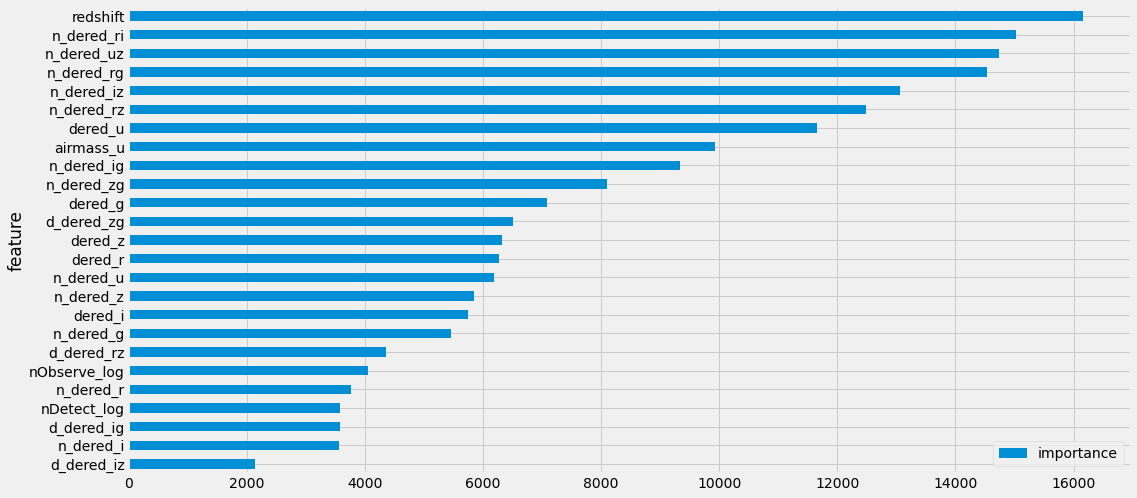

In [85]:
imp = pd.DataFrame({'feature': df[cols_to_use_best + ['n_dered_uz','n_dered_iz']].columns, 'importance': lgb_clf3.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

<h1> RF </h1>

RF1

In [86]:
y = df[target_col].values[:320000]
trn = df[cols_to_use_predict].iloc[:320000].values
tst = df[cols_to_use_predict].iloc[320000:].values
feature_name = df[cols_to_use_predict].columns.tolist()

In [95]:
params = {
    
    "n_estimators": 1000,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
 
   
    "min_samples_leaf": hp.choice('min_samples_leaf', np.linspace(6, 16, 2, dtype=int)),
    "min_samples_split" : hp.choice('min_samples_choice', np.linspace(4,20,4, dtype = int))

}

In [98]:
def objective(hyperparams):
    model = RandomForestClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn)
    score = cross_val_score(model, X_trn, y_trn, scoring='accuracy', cv=cv).mean()

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

  0%|          | 0/10 [11:34<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [99]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst_rf0 = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    rfclf = RandomForestClassifier(n_estimators=100,
                                 min_samples_leaf=10,
                                 max_features='auto',
                                 max_samples=.5,
                                 random_state=seed,
                                 n_jobs=-1)
    rfclf.fit(trn[i_trn], y[i_trn])
    p_val[i_val, :] = rfclf.predict_proba(trn[i_val])
    p_tst_rf0 += rfclf.predict_proba(tst) / n_fold

training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5


In [100]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.2031%


In [101]:
#pval ptst
algo_name = 'rf1'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst_rf0, fmt='%.6f', delimiter=',')

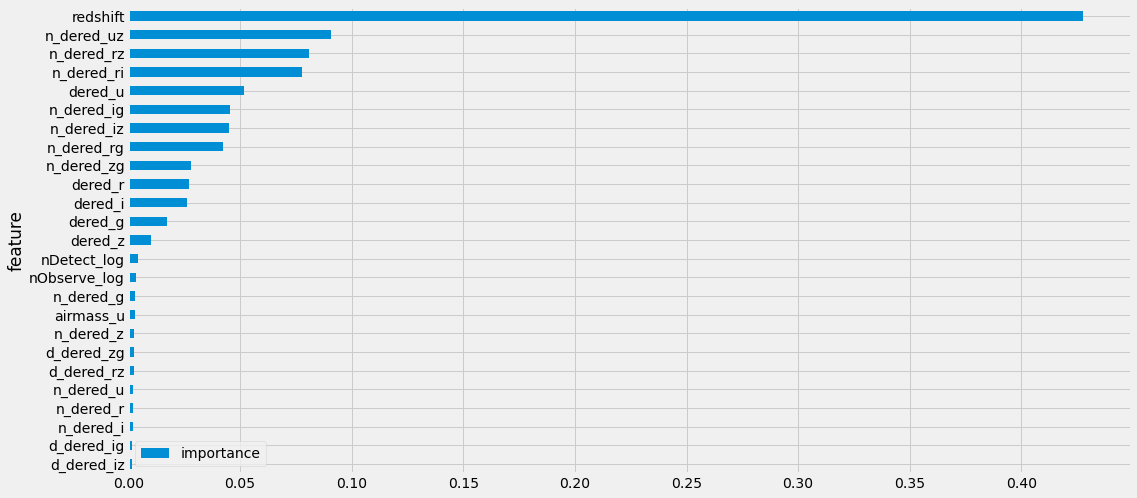

In [102]:
imp = pd.DataFrame({'feature': df[cols_to_use_predict].columns, 'importance': rfclf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

RF2

In [103]:
y = df[target_col].values[:320000]
trn = df[cols_to_use_best].iloc[:320000].values
tst = df[cols_to_use_best].iloc[320000:].values
feature_name = df[cols_to_use_best].columns.tolist()

In [104]:
params = {
    "objective": "multiclass",
    "n_estimators": 1000,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
    "max_sample": hp.quniform("maxsample", .5, 1.0, 0.05),
    "min_samples_leaf": hp.choice('min_samples_leaf', np.linspace(6, 16, 2, dtype=int)),
    "min_samples_split" : hp.choice('min_samples_choice', np.linspace(4,20,4, dtype = int))

}

In [105]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst_rf1 = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    rfclf1 = RandomForestClassifier(n_estimators=100,
                                 min_samples_leaf=10,
                                 max_features='auto',
                                 max_samples=.5,
                                 random_state=seed,
                                 n_jobs=-1)
    rfclf1.fit(trn[i_trn], y[i_trn])
    p_val[i_val, :] = rfclf1.predict_proba(trn[i_val])
    p_tst_rf1 += rfclf1.predict_proba(tst) / n_fold

training model for CV #1
training model for CV #2
training model for CV #3
training model for CV #4
training model for CV #5


In [106]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

92.7381%


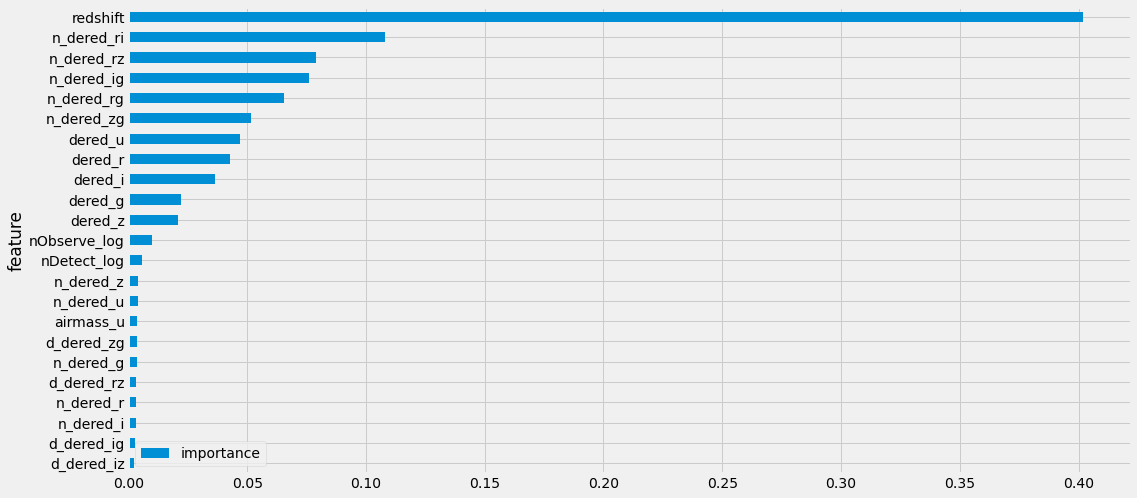

In [107]:
imp = pd.DataFrame({'feature': df[cols_to_use_best].columns, 'importance': rfclf1.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [108]:
#pval ptst
algo_name = 'rf2'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst_rf1, fmt='%.6f', delimiter=',')